# 0. Library

In [10]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle
import os
import torch

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # Added cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold # Added for feature selection

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
# import scorecardpy as sc # For LR+WOE variant (Keep commented if not using)

# --- Bayesian Optimization ---
import optuna # Added Optuna

# --- Display Options ---
# Set display options (optional but helpful)
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', 100)    # Show more rows
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Utility Function + Configuration

## 1.1 Helper Function

In [11]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


## 1.2 Early Stopping

In [12]:
# Define custom early stopping callbacks for Optuna
class EarlyStoppingCallback:
    def __init__(self, patience=5, min_improvement=0.001):
        self.patience = patience
        self.min_improvement = min_improvement
        self.best_score = None
        self.no_improvement_count = 0
        self.trial_history = []
        print(f"EarlyStoppingCallback initialized: patience={patience}, min_improvement={min_improvement}")
        
    def __call__(self, study, trial):
        current_score = trial.value
        trial_number = trial.number
        
        # Skip if the trial failed
        if current_score is None:
            print(f"Trial {trial_number} failed, skipping")
            return False
        
        # Initialize best_score for the first time
        if self.best_score is None:
            self.best_score = current_score
            print(f"First trial, best_score initialized to {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "first"))
            return False
            
        # Check if current score improved
        improvement = current_score - self.best_score if study.direction == optuna.study.StudyDirection.MAXIMIZE else self.best_score - current_score
        
        if improvement > self.min_improvement:
            old_best = self.best_score
            self.best_score = current_score
            self.no_improvement_count = 0
            print(f"Trial {trial_number}: New best {self.best_score:.4f} (improved by {improvement:.4f})")
            self.trial_history.append((trial_number, current_score, "improved"))
        else:
            self.no_improvement_count += 1
            print(f"Trial {trial_number}: No improvement ({self.no_improvement_count}/{self.patience}). Score: {current_score:.4f}, Best: {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "no_imp"))
            
        # Stop if no improvement for patience trials
        if self.no_improvement_count >= self.patience:
            print(f"EARLY STOPPING TRIGGERED after {self.patience} trials without {self.min_improvement:.4f} improvement")
            print(f"Trial history: {self.trial_history}")
            return True
            
        return False

class TimeoutCallback:
    """Stop optimization after a specified amount of time."""
    def __init__(self, timeout=3600):  # timeout in seconds (default: 1 hour)
        self.start_time = time.time()
        self.timeout = timeout
        
    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.timeout:
            print(f"Timeout: optimization stopped after {elapsed_time/60:.2f} minutes")
            return True
        return False

## 1.3 Configuration

In [13]:
# --- GPU Configuration for PyTorch ---
def setup_device():
    """Setup and configure PyTorch device (GPU if available)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print GPU information
        gpu_props = torch.cuda.get_device_properties(0)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Set memory usage behavior
        torch.backends.cudnn.benchmark = True  # May speed up training if input sizes don't vary
        # torch.backends.cudnn.deterministic = True  # Uncomment for full reproducibility (but slower)
        
        # Optional: Set PyTorch to allocate memory as needed rather than all at once
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.9)  # Use up to 90% of GPU memory
            
        # Print memory usage
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
        
        # Check if MPS is available (Apple Silicon GPU)
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon GPU (MPS)")
    
    # Set default dtype for better numerical precision if needed
    # torch.set_default_dtype(torch.float32)  # Default is already float32
    # For reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    return device

# Set up device
device = setup_device()

Using GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB
CUDA Version: 12.6
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


In [14]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/' # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True) # Create output dir if needed
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
OPTUNA_N_TRIALS = 100 # Number of trials for Optuna optimization (adjust as needed)

# --- Check for GPU ---
# Define device_name globally before any model uses it
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Data Loading and Preprocessing

## 2.1 Loading, Preprocess

In [15]:
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    test_df = pd.read_csv(DATA_PATH + 'test.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train.csv' and 'test.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 114)
Test shape: (61502, 114)


In [16]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 112)
Prepared X_test shape: (61502, 112)
Number of features: 112


# 3. Model 1: Logistic Regression with SGD

In [17]:
# print out the class distribution
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\nClass distribution in test data:")
print(y_test.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\n" + "="*60)


Class distribution in training data:
TARGET
0   0.92
1   0.08

Class distribution in test data:
TARGET
0   0.92
1   0.08




Model 2: SGDClassifier with Optuna Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7305
Gini Coefficient: 0.4611
KS Statistic:   0.3427
Accuracy:       0.6548
Precision:      0.1481
Recall (TPR):   0.6892
F1-Score:       0.2438
Brier Score:    0.2220
Log Loss:       0.6396

Confusion Matrix:
[[36850 19687]
 [ 1543  3422]]


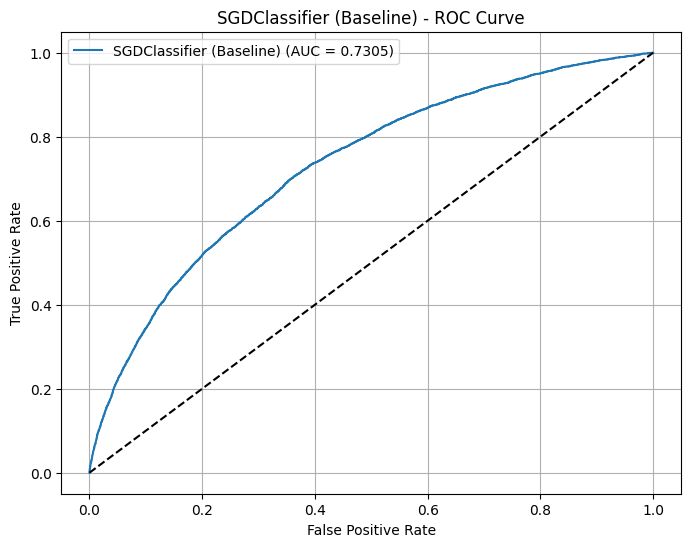

[I 2025-04-09 22:25:10,590] Using an existing study with name 'sgd_optimization' instead of creating a new one.



--- Optuna Optimization for SGDClassifier ---
EarlyStoppingCallback initialized: patience=50, min_improvement=0.002
Starting Optuna optimization for SGD with max 100 trials (early stopping enabled)...


[I 2025-04-09 22:25:27,366] Trial 262 finished with value: 0.7481771536264252 and parameters: {'alpha': 0.002136682759967349, 'max_iter': 1577, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.018569400477640982}. Best is trial 138 with value: 0.7524510482039067.


First trial, best_score initialized to 0.7482


[I 2025-04-09 22:25:35,494] Trial 263 finished with value: 0.7480750882657189 and parameters: {'alpha': 0.0007116669934866092, 'max_iter': 1712, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.011272982643180322}. Best is trial 138 with value: 0.7524510482039067.


Trial 263: No improvement (1/50). Score: 0.7481, Best: 0.7482


[I 2025-04-09 22:25:48,019] Trial 264 finished with value: 0.7488919006037464 and parameters: {'alpha': 0.0016399537837306943, 'max_iter': 1891, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0045060895990620175}. Best is trial 138 with value: 0.7524510482039067.


Trial 264: No improvement (2/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:26:03,588] Trial 265 finished with value: 0.7489778056156744 and parameters: {'alpha': 0.0010152672811265383, 'max_iter': 1514, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0071335214226546685}. Best is trial 138 with value: 0.7524510482039067.


Trial 265: No improvement (3/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:26:20,478] Trial 266 finished with value: 0.748975000154189 and parameters: {'alpha': 0.0005899822905404756, 'max_iter': 2165, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.021039428140545942}. Best is trial 138 with value: 0.7524510482039067.


Trial 266: No improvement (4/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:26:35,148] Trial 267 finished with value: 0.7489297320292213 and parameters: {'alpha': 0.001384673296921273, 'max_iter': 1842, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008617110439935714}. Best is trial 138 with value: 0.7524510482039067.


Trial 267: No improvement (5/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:26:49,604] Trial 268 finished with value: 0.7489776686824352 and parameters: {'alpha': 0.0008460930783533198, 'max_iter': 1747, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.013584713392531382}. Best is trial 138 with value: 0.7524510482039067.


Trial 268: No improvement (6/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:27:06,802] Trial 269 finished with value: 0.7489580783230073 and parameters: {'alpha': 0.0011475826197359016, 'max_iter': 1261, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.06278110931252254}. Best is trial 138 with value: 0.7524510482039067.


Trial 269: No improvement (7/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:27:19,993] Trial 270 finished with value: 0.7486395627024761 and parameters: {'alpha': 0.0030924608016130693, 'max_iter': 2024, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.003454310208887524}. Best is trial 138 with value: 0.7524510482039067.


Trial 270: No improvement (8/50). Score: 0.7486, Best: 0.7482


[I 2025-04-09 22:27:35,249] Trial 271 finished with value: 0.7490289796823804 and parameters: {'alpha': 2.0503273074829144e-05, 'max_iter': 1472, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01634040444116507}. Best is trial 138 with value: 0.7524510482039067.


Trial 271: No improvement (9/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:27:47,889] Trial 272 finished with value: 0.7488338553829582 and parameters: {'alpha': 0.0018851788781488706, 'max_iter': 1639, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01067466074083611}. Best is trial 138 with value: 0.7524510482039067.


Trial 272: No improvement (10/50). Score: 0.7488, Best: 0.7482


[I 2025-04-09 22:28:00,199] Trial 273 finished with value: 0.7489959899045247 and parameters: {'alpha': 0.0008256106160682035, 'max_iter': 1561, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.006314718884484376}. Best is trial 138 with value: 0.7524510482039067.


Trial 273: No improvement (11/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:28:12,332] Trial 274 finished with value: 0.7489297175566023 and parameters: {'alpha': 0.0014321046763049732, 'max_iter': 1924, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005273895579703037}. Best is trial 138 with value: 0.7524510482039067.


Trial 274: No improvement (12/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:28:25,855] Trial 275 finished with value: 0.7489423911175348 and parameters: {'alpha': 0.0010920168167470696, 'max_iter': 1690, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008582505305157846}. Best is trial 138 with value: 0.7524510482039067.


Trial 275: No improvement (13/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:28:40,622] Trial 276 finished with value: 0.7490163862774903 and parameters: {'alpha': 0.00048727768603060905, 'max_iter': 1802, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.013736091857615092}. Best is trial 138 with value: 0.7524510482039067.


Trial 276: No improvement (14/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:28:48,799] Trial 277 finished with value: 0.7459299455782776 and parameters: {'alpha': 0.0006877770561228249, 'max_iter': 1605, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


Trial 277: No improvement (15/50). Score: 0.7459, Best: 0.7482


[I 2025-04-09 22:28:58,327] Trial 278 finished with value: 0.748887172510521 and parameters: {'alpha': 0.0009756806413324696, 'max_iter': 1359, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.017894601305776827}. Best is trial 138 with value: 0.7524510482039067.


Trial 278: No improvement (16/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:29:10,665] Trial 279 finished with value: 0.7489250005961605 and parameters: {'alpha': 0.00140264630616834, 'max_iter': 1411, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009998694988798193}. Best is trial 138 with value: 0.7524510482039067.


Trial 279: No improvement (17/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:29:21,572] Trial 280 finished with value: 0.7476703804074407 and parameters: {'alpha': 0.0026486162786335554, 'max_iter': 1669, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.0014660990065241118}. Best is trial 138 with value: 0.7524510482039067.


Trial 280: No improvement (18/50). Score: 0.7477, Best: 0.7482


[I 2025-04-09 22:29:38,754] Trial 281 finished with value: 0.7489991148769014 and parameters: {'alpha': 0.0017220664318210596, 'max_iter': 1733, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02283688034010667}. Best is trial 138 with value: 0.7524510482039067.


Trial 281: No improvement (19/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:29:51,308] Trial 282 finished with value: 0.7489540527084315 and parameters: {'alpha': 0.001171092086237043, 'max_iter': 1542, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0022379825542251483}. Best is trial 138 with value: 0.7524510482039067.


Trial 282: No improvement (20/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:29:58,889] Trial 283 finished with value: 0.6945543109177628 and parameters: {'alpha': 0.0008267437650107303, 'max_iter': 2055, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.012273320822835682}. Best is trial 138 with value: 0.7524510482039067.


Trial 283: No improvement (21/50). Score: 0.6946, Best: 0.7482


[I 2025-04-09 22:30:11,461] Trial 284 finished with value: 0.7488062182474919 and parameters: {'alpha': 0.0020468124060236863, 'max_iter': 1975, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.007913501379374823}. Best is trial 138 with value: 0.7524510482039067.


Trial 284: No improvement (22/50). Score: 0.7488, Best: 0.7482


[I 2025-04-09 22:30:24,616] Trial 285 finished with value: 0.7489875534810577 and parameters: {'alpha': 0.0005933318374944381, 'max_iter': 1491, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.015669747651196345}. Best is trial 138 with value: 0.7524510482039067.


Trial 285: No improvement (23/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:30:27,985] Trial 286 finished with value: 0.7287443152945053 and parameters: {'alpha': 0.0009315566485587432, 'max_iter': 1625, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.00015958326610074198}. Best is trial 138 with value: 0.7524510482039067.


Trial 286: No improvement (24/50). Score: 0.7287, Best: 0.7482


[I 2025-04-09 22:30:38,111] Trial 287 finished with value: 0.748919811605691 and parameters: {'alpha': 0.0014171193989131728, 'max_iter': 1782, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00302155212002557}. Best is trial 138 with value: 0.7524510482039067.


Trial 287: No improvement (25/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:30:50,753] Trial 288 finished with value: 0.7489716413933551 and parameters: {'alpha': 0.0011090706596291783, 'max_iter': 1570, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.019870927936821083}. Best is trial 138 with value: 0.7524510482039067.


Trial 288: No improvement (26/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:31:05,767] Trial 289 finished with value: 0.7490040355672845 and parameters: {'alpha': 0.0007322675510401229, 'max_iter': 1718, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.07873714257730526}. Best is trial 138 with value: 0.7524510482039067.


Trial 289: No improvement (27/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:31:16,680] Trial 290 finished with value: 0.7488651585440875 and parameters: {'alpha': 0.0017704734399991526, 'max_iter': 1861, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0038696057092193364}. Best is trial 138 with value: 0.7524510482039067.


Trial 290: No improvement (28/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:31:28,398] Trial 291 finished with value: 0.7489479419234739 and parameters: {'alpha': 0.0012867389990605692, 'max_iter': 1643, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.006728171832234746}. Best is trial 138 with value: 0.7524510482039067.


Trial 291: No improvement (29/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:31:42,431] Trial 292 finished with value: 0.7489633830944271 and parameters: {'alpha': 0.0009708493621004778, 'max_iter': 1485, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02983988580906852}. Best is trial 138 with value: 0.7524510482039067.


Trial 292: No improvement (30/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:31:54,856] Trial 293 finished with value: 0.7487891884283087 and parameters: {'alpha': 0.0022887800228796177, 'max_iter': 1315, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009985714438410228}. Best is trial 138 with value: 0.7524510482039067.


Trial 293: No improvement (31/50). Score: 0.7488, Best: 0.7482


[I 2025-04-09 22:32:06,182] Trial 294 finished with value: 0.7488977631276283 and parameters: {'alpha': 0.001562713713321075, 'max_iter': 1683, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.012382132817314338}. Best is trial 138 with value: 0.7524510482039067.


Trial 294: No improvement (32/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:32:20,993] Trial 295 finished with value: 0.7490115479697065 and parameters: {'alpha': 0.000765379130364698, 'max_iter': 1594, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.03668133929182934}. Best is trial 138 with value: 0.7524510482039067.


Trial 295: No improvement (33/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:32:26,820] Trial 296 finished with value: 0.7488746848670759 and parameters: {'alpha': 0.0012313752970443252, 'max_iter': 1428, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.000650563651867391}. Best is trial 138 with value: 0.7524510482039067.


Trial 296: No improvement (34/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:32:38,821] Trial 297 finished with value: 0.7489851387802793 and parameters: {'alpha': 0.000519251748695671, 'max_iter': 1924, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004865782579530069}. Best is trial 138 with value: 0.7524510482039067.


Trial 297: No improvement (35/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:32:51,510] Trial 298 finished with value: 0.7489625058310738 and parameters: {'alpha': 0.0009572989511917779, 'max_iter': 1539, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01481818694512441}. Best is trial 138 with value: 0.7524510482039067.


Trial 298: No improvement (36/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:33:03,529] Trial 299 finished with value: 0.7490152896982987 and parameters: {'alpha': 0.0006595767556788195, 'max_iter': 2006, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008499059725323105}. Best is trial 138 with value: 0.7524510482039067.


Trial 299: No improvement (37/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:33:17,522] Trial 300 finished with value: 0.7482091381139154 and parameters: {'alpha': 0.001620614770633053, 'max_iter': 2341, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.025472590755673902}. Best is trial 138 with value: 0.7524510482039067.


Trial 300: No improvement (38/50). Score: 0.7482, Best: 0.7482


[I 2025-04-09 22:33:29,989] Trial 301 finished with value: 0.7489544880002731 and parameters: {'alpha': 0.0011178645603601698, 'max_iter': 1755, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011878459694778505}. Best is trial 138 with value: 0.7524510482039067.


Trial 301: No improvement (39/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:33:36,421] Trial 302 finished with value: 0.7464590355754114 and parameters: {'alpha': 0.0008555901391742907, 'max_iter': 1671, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


Trial 302: No improvement (40/50). Score: 0.7465, Best: 0.7482


[I 2025-04-09 22:33:50,743] Trial 303 finished with value: 0.7489001499964475 and parameters: {'alpha': 0.0013306758048215787, 'max_iter': 1812, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.017776740140692686}. Best is trial 138 with value: 0.7524510482039067.


Trial 303: No improvement (41/50). Score: 0.7489, Best: 0.7482


[I 2025-04-09 22:34:02,836] Trial 304 finished with value: 0.7241667217182819 and parameters: {'alpha': 0.5183501465725145, 'max_iter': 1589, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0062126561607451}. Best is trial 138 with value: 0.7524510482039067.


Trial 304: No improvement (42/50). Score: 0.7242, Best: 0.7482


[I 2025-04-09 22:34:15,156] Trial 305 finished with value: 0.748829731799886 and parameters: {'alpha': 0.0019862701330527347, 'max_iter': 2220, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0208667477540404}. Best is trial 138 with value: 0.7524510482039067.


Trial 305: No improvement (43/50). Score: 0.7488, Best: 0.7482


[I 2025-04-09 22:34:28,643] Trial 306 finished with value: 0.7489698534682974 and parameters: {'alpha': 0.001021527922483475, 'max_iter': 1704, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.046630771063556765}. Best is trial 138 with value: 0.7524510482039067.


Trial 306: No improvement (44/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:34:38,852] Trial 307 finished with value: 0.7485376120094414 and parameters: {'alpha': 0.003902760456652181, 'max_iter': 1457, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0025961573864457244}. Best is trial 138 with value: 0.7524510482039067.


Trial 307: No improvement (45/50). Score: 0.7485, Best: 0.7482


[I 2025-04-09 22:34:50,821] Trial 308 finished with value: 0.7490346217771455 and parameters: {'alpha': 0.0006240357709231181, 'max_iter': 1645, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009393703606747782}. Best is trial 138 with value: 0.7524510482039067.


Trial 308: No improvement (46/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:34:57,048] Trial 309 finished with value: 0.6964806365155705 and parameters: {'alpha': 0.0015027737757193384, 'max_iter': 2782, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.013635374332357342}. Best is trial 138 with value: 0.7524510482039067.


Trial 309: No improvement (47/50). Score: 0.6965, Best: 0.7482


[I 2025-04-09 22:35:11,731] Trial 310 finished with value: 0.7489900628104975 and parameters: {'alpha': 0.0004189807119371209, 'max_iter': 1514, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0072206925437848955}. Best is trial 138 with value: 0.7524510482039067.


Trial 310: No improvement (48/50). Score: 0.7490, Best: 0.7482


[I 2025-04-09 22:35:25,706] Trial 311 finished with value: 0.7477355127583147 and parameters: {'alpha': 0.0008018361541255313, 'max_iter': 1866, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.004289338954974491}. Best is trial 138 with value: 0.7524510482039067.


Trial 311: No improvement (49/50). Score: 0.7477, Best: 0.7482


[I 2025-04-09 22:35:38,054] Trial 312 finished with value: 0.7489587162315118 and parameters: {'alpha': 0.001190606433940863, 'max_iter': 1736, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.010251125126406113}. Best is trial 138 with value: 0.7524510482039067.


Trial 312: No improvement (50/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:35:51,440] Trial 313 finished with value: 0.7487071498321499 and parameters: {'alpha': 0.0024825535142539014, 'max_iter': 1608, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.10881291300443525}. Best is trial 138 with value: 0.7524510482039067.


Trial 313: No improvement (51/50). Score: 0.7487, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:35:59,914] Trial 314 finished with value: 0.7488771574583293 and parameters: {'alpha': 0.0009047403887501435, 'max_iter': 1946, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01691582799499093}. Best is trial 138 with value: 0.7524510482039067.


Trial 314: No improvement (52/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:36:11,993] Trial 315 finished with value: 0.748875219240692 and parameters: {'alpha': 0.0016831752504079041, 'max_iter': 2107, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011408978734300444}. Best is trial 138 with value: 0.7524510482039067.


Trial 315: No improvement (53/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:36:24,021] Trial 316 finished with value: 0.7489234130612089 and parameters: {'alpha': 0.0012329076229227012, 'max_iter': 1791, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.014091804388078331}. Best is trial 138 with value: 0.7524510482039067.


Trial 316: No improvement (54/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:36:36,070] Trial 317 finished with value: 0.7490030313901974 and parameters: {'alpha': 0.0007003078072747485, 'max_iter': 1559, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005543487106759718}. Best is trial 138 with value: 0.7524510482039067.


Trial 317: No improvement (55/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:36:47,380] Trial 318 finished with value: 0.7489722592628489 and parameters: {'alpha': 0.0009977002845494342, 'max_iter': 1668, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009011284057666913}. Best is trial 138 with value: 0.7524510482039067.


Trial 318: No improvement (56/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:36:59,511] Trial 319 finished with value: 0.7482803823630254 and parameters: {'alpha': 0.001441514191001371, 'max_iter': 1381, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.02675874488943326}. Best is trial 138 with value: 0.7524510482039067.


Trial 319: No improvement (57/50). Score: 0.7483, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:37:12,942] Trial 320 finished with value: 0.7488611440622953 and parameters: {'alpha': 0.0018363826696249435, 'max_iter': 1515, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00793423342879695}. Best is trial 138 with value: 0.7524510482039067.


Trial 320: No improvement (58/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:37:23,404] Trial 321 finished with value: 0.7489803728355893 and parameters: {'alpha': 0.0005456803772806475, 'max_iter': 2038, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.002035020007864675}. Best is trial 138 with value: 0.7524510482039067.


Trial 321: No improvement (59/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:37:33,376] Trial 322 finished with value: 0.7489734705097125 and parameters: {'alpha': 0.0011019771370605331, 'max_iter': 1605, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0017225770879598214}. Best is trial 138 with value: 0.7524510482039067.


Trial 322: No improvement (60/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:37:49,107] Trial 323 finished with value: 0.7490032584989841 and parameters: {'alpha': 0.0008143013831363365, 'max_iter': 1719, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.08417899368258563}. Best is trial 138 with value: 0.7524510482039067.


Trial 323: No improvement (61/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:01,681] Trial 324 finished with value: 0.7488868040153813 and parameters: {'alpha': 0.0013760589151300298, 'max_iter': 1896, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02019075993676205}. Best is trial 138 with value: 0.7524510482039067.


Trial 324: No improvement (62/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:12,447] Trial 325 finished with value: 0.7488141258637342 and parameters: {'alpha': 0.0020526051239869907, 'max_iter': 1447, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0032971001649318428}. Best is trial 138 with value: 0.7524510482039067.


Trial 325: No improvement (63/50). Score: 0.7488, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:18,473] Trial 326 finished with value: 0.7463558079520894 and parameters: {'alpha': 0.0010010484506288945, 'max_iter': 1638, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


Trial 326: No improvement (64/50). Score: 0.7464, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:26,809] Trial 327 finished with value: 0.748975536754362 and parameters: {'alpha': 0.0007273777049839901, 'max_iter': 1549, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00039842036076676815}. Best is trial 138 with value: 0.7524510482039067.


Trial 327: No improvement (65/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:39,294] Trial 328 finished with value: 0.7489430490650498 and parameters: {'alpha': 0.0012127942463611933, 'max_iter': 1782, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011289740700349684}. Best is trial 138 with value: 0.7524510482039067.


Trial 328: No improvement (66/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:38:51,738] Trial 329 finished with value: 0.7486583314624691 and parameters: {'alpha': 0.0029643931937019226, 'max_iter': 1685, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.014850396360056955}. Best is trial 138 with value: 0.7524510482039067.


Trial 329: No improvement (67/50). Score: 0.7487, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:02,678] Trial 330 finished with value: 0.7489132777749538 and parameters: {'alpha': 0.0015026918097514335, 'max_iter': 2006, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.006352612786323971}. Best is trial 138 with value: 0.7524510482039067.


Trial 330: No improvement (68/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:15,958] Trial 331 finished with value: 0.7489819458979221 and parameters: {'alpha': 0.0009486888799087931, 'max_iter': 1487, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.017422141092584834}. Best is trial 138 with value: 0.7524510482039067.


Trial 331: No improvement (69/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:20,398] Trial 332 finished with value: 0.716704896645797 and parameters: {'alpha': 0.13392532875555407, 'max_iter': 1743, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.0074215965256526455}. Best is trial 138 with value: 0.7524510482039067.


Trial 332: No improvement (70/50). Score: 0.7167, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:34,636] Trial 333 finished with value: 0.748987320805879 and parameters: {'alpha': 0.0006055584717357635, 'max_iter': 2147, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0677806653437181}. Best is trial 138 with value: 0.7524510482039067.


Trial 333: No improvement (71/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:47,151] Trial 334 finished with value: 0.748818776027474 and parameters: {'alpha': 0.0017298093787060588, 'max_iter': 1842, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.033347841315132576}. Best is trial 138 with value: 0.7524510482039067.


Trial 334: No improvement (72/50). Score: 0.7488, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:39:51,386] Trial 335 finished with value: 0.7480452858038283 and parameters: {'alpha': 0.0011966509459296175, 'max_iter': 1582, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.012584016120295043}. Best is trial 138 with value: 0.7524510482039067.


Trial 335: No improvement (73/50). Score: 0.7480, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:40:02,724] Trial 336 finished with value: 0.7489889873835948 and parameters: {'alpha': 0.0007942019582167824, 'max_iter': 1635, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00536103320999701}. Best is trial 138 with value: 0.7524510482039067.


Trial 336: No improvement (74/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:40:19,045] Trial 337 finished with value: 0.7489682648200673 and parameters: {'alpha': 0.0004905618326492548, 'max_iter': 1711, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02423661819701847}. Best is trial 138 with value: 0.7524510482039067.


Trial 337: No improvement (75/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:40:30,854] Trial 338 finished with value: 0.7478241920599341 and parameters: {'alpha': 0.0023570413220618987, 'max_iter': 1524, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.010440647474209664}. Best is trial 138 with value: 0.7524510482039067.


Trial 338: No improvement (76/50). Score: 0.7478, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:40:42,057] Trial 339 finished with value: 0.7489748064437531 and parameters: {'alpha': 0.0010132764068500537, 'max_iter': 1966, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004191630219966506}. Best is trial 138 with value: 0.7524510482039067.


Trial 339: No improvement (77/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:40:56,031] Trial 340 finished with value: 0.7490079899320448 and parameters: {'alpha': 0.0014394314854126343, 'max_iter': 1638, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008945946145247798}. Best is trial 138 with value: 0.7524510482039067.


Trial 340: No improvement (78/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:41:08,517] Trial 341 finished with value: 0.7489822709752053 and parameters: {'alpha': 0.0007308984521360676, 'max_iter': 1399, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.015391080267784896}. Best is trial 138 with value: 0.7524510482039067.


Trial 341: No improvement (79/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:41:20,993] Trial 342 finished with value: 0.7489331920983865 and parameters: {'alpha': 0.001260373376935143, 'max_iter': 1567, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.012649950588665852}. Best is trial 138 with value: 0.7524510482039067.


Trial 342: No improvement (80/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:41:35,252] Trial 343 finished with value: 0.7488119839161558 and parameters: {'alpha': 0.0019372637542980813, 'max_iter': 1913, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.020521842990909058}. Best is trial 138 with value: 0.7524510482039067.


Trial 343: No improvement (81/50). Score: 0.7488, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:41:46,100] Trial 344 finished with value: 0.7490016509250219 and parameters: {'alpha': 0.0009001629623745625, 'max_iter': 2062, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.007158097549824747}. Best is trial 138 with value: 0.7524510482039067.


Trial 344: No improvement (82/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:41:58,465] Trial 345 finished with value: 0.7489603828092275 and parameters: {'alpha': 0.0010990757332494936, 'max_iter': 1686, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.010367850400835328}. Best is trial 138 with value: 0.7524510482039067.


Trial 345: No improvement (83/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:42:10,308] Trial 346 finished with value: 0.748914645994067 and parameters: {'alpha': 0.0015675544483338356, 'max_iter': 1806, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004854582423337486}. Best is trial 138 with value: 0.7524510482039067.


Trial 346: No improvement (84/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:42:26,323] Trial 347 finished with value: 0.7489723583446237 and parameters: {'alpha': 0.0008560796774506445, 'max_iter': 2276, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.05630598927337874}. Best is trial 138 with value: 0.7524510482039067.


Trial 347: No improvement (85/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:42:36,965] Trial 348 finished with value: 0.7489733558420407 and parameters: {'alpha': 0.00036719550235829603, 'max_iter': 1460, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0029526424879410683}. Best is trial 138 with value: 0.7524510482039067.


Trial 348: No improvement (86/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:42:51,804] Trial 349 finished with value: 0.749009463912603 and parameters: {'alpha': 0.000580334922918307, 'max_iter': 1336, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01462940592961756}. Best is trial 138 with value: 0.7524510482039067.


Trial 349: No improvement (87/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:42:57,108] Trial 350 finished with value: 0.7469793217672173 and parameters: {'alpha': 0.0013085994719319982, 'max_iter': 1746, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


Trial 350: No improvement (88/50). Score: 0.7470, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:43:08,906] Trial 351 finished with value: 0.7489516413474882 and parameters: {'alpha': 0.0010596316929824328, 'max_iter': 1613, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008673045438671381}. Best is trial 138 with value: 0.7524510482039067.


Trial 351: No improvement (89/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:43:21,326] Trial 352 finished with value: 0.7487901525273746 and parameters: {'alpha': 0.002125053333364927, 'max_iter': 1675, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01732451415119522}. Best is trial 138 with value: 0.7524510482039067.


Trial 352: No improvement (90/50). Score: 0.7488, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:43:30,394] Trial 353 finished with value: 0.7489700104405472 and parameters: {'alpha': 7.696625938901357e-05, 'max_iter': 1536, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.04159064917932696}. Best is trial 138 with value: 0.7524510482039067.


Trial 353: No improvement (91/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:43:40,774] Trial 354 finished with value: 0.7489672606429801 and parameters: {'alpha': 0.0007414968261856808, 'max_iter': 1860, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.002354825583640481}. Best is trial 138 with value: 0.7524510482039067.


Trial 354: No improvement (92/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:43:55,972] Trial 355 finished with value: 0.7488307359769731 and parameters: {'alpha': 0.00162786760965872, 'max_iter': 1585, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.09786279069049358}. Best is trial 138 with value: 0.7524510482039067.


Trial 355: No improvement (93/50). Score: 0.7488, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:01,707] Trial 356 finished with value: 0.7166537348251529 and parameters: {'alpha': 0.0011765153390581834, 'max_iter': 1987, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.006060639241596204}. Best is trial 138 with value: 0.7524510482039067.


Trial 356: No improvement (94/50). Score: 0.7167, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:10,723] Trial 357 finished with value: 0.7485585861738798 and parameters: {'alpha': 0.0008776727940065218, 'max_iter': 1769, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.0012001650045072065}. Best is trial 138 with value: 0.7524510482039067.


Trial 357: No improvement (95/50). Score: 0.7486, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:25,820] Trial 358 finished with value: 0.7487326505864293 and parameters: {'alpha': 0.005828912955902084, 'max_iter': 1507, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.3434616536341675}. Best is trial 138 with value: 0.7524510482039067.


Trial 358: No improvement (96/50). Score: 0.7487, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:41,395] Trial 359 finished with value: 0.7489939659644529 and parameters: {'alpha': 0.0005964198925181374, 'max_iter': 1430, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.13532961352368278}. Best is trial 138 with value: 0.7524510482039067.


Trial 359: No improvement (97/50). Score: 0.7490, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:53,922] Trial 360 finished with value: 0.7488748151206448 and parameters: {'alpha': 0.00151695202377095, 'max_iter': 1659, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.023345040375920532}. Best is trial 138 with value: 0.7524510482039067.


Trial 360: No improvement (98/50). Score: 0.7489, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

[I 2025-04-09 22:44:58,954] Trial 361 finished with value: 0.7480461519343979 and parameters: {'alpha': 0.0009911439286051185, 'max_iter': 1721, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.012630863830527186}. Best is trial 138 with value: 0.7524510482039067.


Trial 361: No improvement (99/50). Score: 0.7480, Best: 0.7482
EARLY STOPPING TRIGGERED after 50 trials without 0.0020 improvement
Trial history: [(262, 0.7481771536264252, 'first'), (263, 0.7480750882657189, 'no_imp'), (264, 0.7488919006037464, 'no_imp'), (265, 0.7489778056156744, 'no_imp'), (266, 0.748975000154189, 'no_imp'), (267, 0.7489297320292213, 'no_imp'), (268, 0.7489776686824352, 'no_imp'), (269, 0.7489580783230073, 'no_imp'), (270, 0.7486395627024761, 'no_imp'), (271, 0.7490289796823804, 'no_imp'), (272, 0.7488338553829582, 'no_imp'), (273, 0.7489959899045247, 'no_imp'), (274, 0.7489297175566023, 'no_imp'), (275, 0.7489423911175348, 'no_imp'), (276, 0.7490163862774903, 'no_imp'), (277, 0.7459299455782776, 'no_imp'), (278, 0.748887172510521, 'no_imp'), (279, 0.7489250005961605, 'no_imp'), (280, 0.7476703804074407, 'no_imp'), (281, 0.7489991148769014, 'no_imp'), (282, 0.7489540527084315, 'no_imp'), (283, 0.6945543109177628, 'no_imp'), (284, 0.7488062182474919, 'no_imp'), (285,

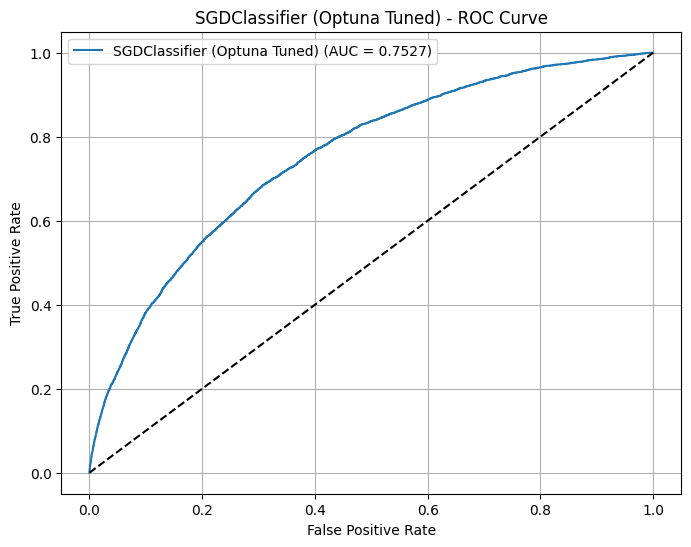


--- Top 50 Feature Importances ---
Sum of importances: 5.0649


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.35930
5,EXT_SOURCE_1,0.24308
16,DAYS_BIRTH,0.20637
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.20352
3,EXT_SOURCE_3,0.20285
70,AGE_EMPLOYED_DIFF_MIN_AGG_NAME_EDUCATION_TYPE_...,0.17668
25,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.17004
45,AGE_EMPLOYED_DIFF_MEAN_AGG_OCCUPATION_TYPE_ORG...,0.16645
42,AMT_INCOME_TOTAL_MEAN_AGG_NAME_EDUCATION_TYPE_...,0.16323
4,EXT_SOURCE_2,0.15021


In [18]:
# --- Model 1: SGDClassifier with Optuna Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Optuna Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline (No change needed here)
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    # ('smote', SMOTE_VARIANT), # Keep SMOTE here
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED,
                            class_weight='balanced', n_jobs=6, tol=1e-5))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for SGDClassifier ---")

# Define the objective function for Optuna
def objective_sgd(trial):
    # Define hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    l1_ratio = 0.15 # Default if penalty is elasticnet, fixed here for simplicity, could also tune
    class_weight_opt = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    eta0 = 0.01 
    if learning_rate != 'optimal':
        eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True)

    # Create the pipeline with suggested parameters
    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', SGDClassifier(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else 0.15, # Apply l1_ratio only if relevant
            max_iter=max_iter,
            class_weight=class_weight_opt,
            learning_rate=learning_rate,
            eta0=eta0,
            random_state=SEED,
            n_jobs=5,
            tol=1e-5 # Use tolerance for convergence
        ))
    ])

    # Evaluate using cross-validation
    try:
        # Using roc_auc as the optimization target
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        # Handle potential errors during CV
        if np.isnan(auc_score):
            return 0.0 # Return low score if CV fails
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0 # Return low score for failed trials

# Create an Optuna study
study_sgd = optuna.create_study(direction='maximize',
                                study_name='sgd_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db', # Save study progress
                                load_if_exists=True) # Resume if exists

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=50, min_improvement=0.002)  
timeout = TimeoutCallback(timeout=3600)

# Run optimization with callbacks
print(f"Starting Optuna optimization for SGD with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build the final pipeline
best_params_sgd_raw = study_sgd.best_params
# Need to prefix with 'model__' for pipeline
best_params_sgd = {f'model__{k}': v for k, v in best_params_sgd_raw.items()}
print(f"\nBest Params (SGDClassifier): {best_params_sgd_raw}")
print(f"Best CV ROC AUC score: {study_sgd.best_value:.4f}")

best_sgd_pipeline = ImblearnPipeline([
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=SEED, n_jobs=8, tol=1e-5, class_weight='balanced'))
])
best_sgd_pipeline.set_params(**best_params_sgd)

# Fit the best pipeline on the full training data
print("\nFitting best SGD pipeline on full training data...")
best_sgd_pipeline.fit(X_train, y_train)

# Step 2.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned SGD model...")
y_prob_oof_sgd = cross_val_predict(best_sgd_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_sgd_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Optuna Tuned)")

# Feature importance via coefficients
final_sgd_model = best_sgd_pipeline.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
     get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_sgd_pipeline # Store the best pipeline

# 4. Model 2: XGBoost


Model 3: XGBoost with Optuna Optimization & GPU

--- Baseline XGBoost Training ---

--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7603
Gini Coefficient: 0.5206
KS Statistic:   0.3954
Accuracy:       0.7497
Precision:      0.1858
Recall (TPR):   0.6207
F1-Score:       0.2859
Brier Score:    0.1667
Log Loss:       0.5001

Confusion Matrix:
[[43027 13510]
 [ 1883  3082]]


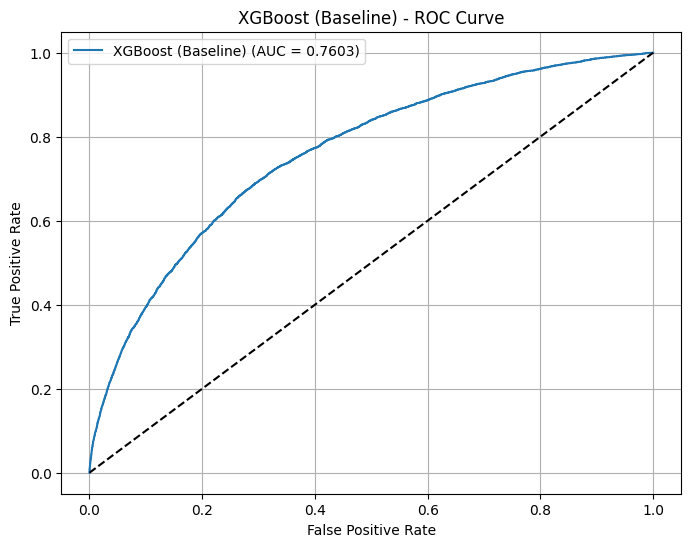


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.11121
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.02006
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.01694
20,CREDIT_GOODS_RATIO,0.01663
101,FLAG_DOCUMENT_3,0.01457
6,CREDIT_ANNUITY_RATIO,0.01457
42,AMT_INCOME_TOTAL_MEAN_AGG_NAME_EDUCATION_TYPE_...,0.01389
25,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.01373
87,CREDIT_GOODS_DIFF,0.01208
64,AMT_INCOME_TOTAL_MEAN_AGG_FLAG_OWN_CAR_FLAG_OW...,0.01201


[I 2025-04-09 22:45:29,349] Using an existing study with name 'xgb_optimization' instead of creating a new one.



--- Optuna Optimization for XGBoost ---
EarlyStoppingCallback initialized: patience=50, min_improvement=0.001
Starting Optuna optimization for XGBoost with max 100 trials (early stopping enabled)...


[I 2025-04-09 22:46:43,462] Trial 197 finished with value: 0.7606789730015968 and parameters: {'n_estimators': 875, 'max_depth': 8, 'learning_rate': 0.017182489740173522, 'subsample': 0.9775430278788074, 'colsample_bytree': 0.6101284070869281, 'gamma': 0.32346280599616234, 'reg_alpha': 0.5874809323577688, 'reg_lambda': 1.3591237885403403e-08}. Best is trial 135 with value: 0.7746124371852164.


First trial, best_score initialized to 0.7607


[I 2025-04-09 22:47:56,735] Trial 198 finished with value: 0.736272001915195 and parameters: {'n_estimators': 848, 'max_depth': 8, 'learning_rate': 0.05995146975751972, 'subsample': 0.6003347540576751, 'colsample_bytree': 0.6879865611690015, 'gamma': 0.3387439188760535, 'reg_alpha': 0.26109915170518083, 'reg_lambda': 5.4367704717492856e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 198: No improvement (1/50). Score: 0.7363, Best: 0.7607


[I 2025-04-09 22:48:59,493] Trial 199 finished with value: 0.7657074248341721 and parameters: {'n_estimators': 949, 'max_depth': 7, 'learning_rate': 0.014185521086401155, 'subsample': 0.9695042580391234, 'colsample_bytree': 0.6188162318608194, 'gamma': 0.34988559905756306, 'reg_alpha': 0.004027647358309639, 'reg_lambda': 3.1966266346261426e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 199: New best 0.7657 (improved by 0.0050)


[I 2025-04-09 22:49:45,274] Trial 200 finished with value: 0.7532926682804305 and parameters: {'n_estimators': 887, 'max_depth': 6, 'learning_rate': 0.06794815843199696, 'subsample': 0.9551663235841129, 'colsample_bytree': 0.8892751690094635, 'gamma': 0.29036405455109665, 'reg_alpha': 0.976414236083222, 'reg_lambda': 9.35779067419708e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 200: No improvement (1/50). Score: 0.7533, Best: 0.7657


[I 2025-04-09 22:51:05,103] Trial 201 finished with value: 0.7629816390116074 and parameters: {'n_estimators': 834, 'max_depth': 8, 'learning_rate': 0.012986238599884183, 'subsample': 0.7397510220800909, 'colsample_bytree': 0.8759119850982651, 'gamma': 0.3113764649497513, 'reg_alpha': 0.4495120433767391, 'reg_lambda': 2.375501888077413e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 201: No improvement (2/50). Score: 0.7630, Best: 0.7657


[I 2025-04-09 22:52:29,848] Trial 202 finished with value: 0.7634742229411625 and parameters: {'n_estimators': 963, 'max_depth': 8, 'learning_rate': 0.010558083794905016, 'subsample': 0.9701868167903904, 'colsample_bytree': 0.6582433804638751, 'gamma': 0.26182418850088174, 'reg_alpha': 0.6605749625615918, 'reg_lambda': 4.500896985517642e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 202: No improvement (3/50). Score: 0.7635, Best: 0.7657


[I 2025-04-09 22:53:57,029] Trial 203 finished with value: 0.7638801826809645 and parameters: {'n_estimators': 975, 'max_depth': 8, 'learning_rate': 0.010138918667608401, 'subsample': 0.9840474572624247, 'colsample_bytree': 0.6329213314788971, 'gamma': 0.2678788379129151, 'reg_alpha': 0.6672697035458393, 'reg_lambda': 3.6436722390320566e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 203: No improvement (4/50). Score: 0.7639, Best: 0.7657


[I 2025-04-09 22:55:18,428] Trial 204 finished with value: 0.7633530231085194 and parameters: {'n_estimators': 930, 'max_depth': 8, 'learning_rate': 0.01197781129568204, 'subsample': 0.9635287066623447, 'colsample_bytree': 0.6309380813627523, 'gamma': 0.2752823732801952, 'reg_alpha': 0.31288342641148603, 'reg_lambda': 6.304442233180331e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 204: No improvement (5/50). Score: 0.7634, Best: 0.7657


[I 2025-04-09 22:56:39,370] Trial 205 finished with value: 0.7637029059036862 and parameters: {'n_estimators': 906, 'max_depth': 8, 'learning_rate': 0.010013790129267217, 'subsample': 0.9740175693863934, 'colsample_bytree': 0.6425184482848066, 'gamma': 0.2890846973476162, 'reg_alpha': 0.4384247116233207, 'reg_lambda': 1.5602684895779077e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 205: No improvement (6/50). Score: 0.7637, Best: 0.7657


[I 2025-04-09 22:58:02,841] Trial 206 finished with value: 0.7635756826784372 and parameters: {'n_estimators': 949, 'max_depth': 8, 'learning_rate': 0.011162282281779654, 'subsample': 0.9554168153811282, 'colsample_bytree': 0.6244121103113187, 'gamma': 0.29899231560677786, 'reg_alpha': 0.1258381118306909, 'reg_lambda': 2.229008510332298e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 206: No improvement (7/50). Score: 0.7636, Best: 0.7657


[I 2025-04-09 23:00:36,743] Trial 207 finished with value: 0.7483961788991133 and parameters: {'n_estimators': 970, 'max_depth': 10, 'learning_rate': 0.015226005596383969, 'subsample': 0.9906832171015838, 'colsample_bytree': 0.650500852269875, 'gamma': 0.31533521759911326, 'reg_alpha': 0.7704464962941003, 'reg_lambda': 4.46508869286993e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 207: No improvement (8/50). Score: 0.7484, Best: 0.7657


[I 2025-04-09 23:01:55,567] Trial 208 finished with value: 0.7598988415158513 and parameters: {'n_estimators': 865, 'max_depth': 8, 'learning_rate': 0.015963526251653527, 'subsample': 0.9784295790529609, 'colsample_bytree': 0.8661670881057136, 'gamma': 0.28205804628293685, 'reg_alpha': 0.21826342390554862, 'reg_lambda': 2.923872198703559e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 208: No improvement (9/50). Score: 0.7599, Best: 0.7657


[I 2025-04-09 23:02:56,759] Trial 209 finished with value: 0.7663062455784758 and parameters: {'n_estimators': 934, 'max_depth': 7, 'learning_rate': 0.013193039706696153, 'subsample': 0.9680268661593764, 'colsample_bytree': 0.6000050338003362, 'gamma': 0.3289603502251142, 'reg_alpha': 0.4773461933562015, 'reg_lambda': 7.594767387368734e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 209: No improvement (10/50). Score: 0.7663, Best: 0.7657


[I 2025-04-09 23:03:47,970] Trial 210 finished with value: 0.7679328170794358 and parameters: {'n_estimators': 985, 'max_depth': 6, 'learning_rate': 0.014426367752296082, 'subsample': 0.9356480207860924, 'colsample_bytree': 0.6150867487570932, 'gamma': 0.30676500504312965, 'reg_alpha': 0.3122252560066276, 'reg_lambda': 5.066409240686854e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 210: New best 0.7679 (improved by 0.0022)


[I 2025-04-09 23:05:09,391] Trial 211 finished with value: 0.7634228284453399 and parameters: {'n_estimators': 907, 'max_depth': 8, 'learning_rate': 0.01225215828684459, 'subsample': 0.9458382601779787, 'colsample_bytree': 0.6383830470752089, 'gamma': 0.2727665148963845, 'reg_alpha': 0.9781434002770438, 'reg_lambda': 1.320556085013468e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 211: No improvement (1/50). Score: 0.7634, Best: 0.7679


[I 2025-04-09 23:05:53,378] Trial 212 finished with value: 0.7681720238623647 and parameters: {'n_estimators': 995, 'max_depth': 5, 'learning_rate': 0.01653261991270485, 'subsample': 0.9599303132516472, 'colsample_bytree': 0.8810656031980231, 'gamma': 0.3205099428939029, 'reg_alpha': 0.5830732925757256, 'reg_lambda': 6.856186266072183e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 212: No improvement (2/50). Score: 0.7682, Best: 0.7679


[I 2025-04-09 23:06:37,459] Trial 213 finished with value: 0.7675337090113449 and parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.013599293784208086, 'subsample': 0.9724043798262811, 'colsample_bytree': 0.8669898555576896, 'gamma': 0.24269127455292652, 'reg_alpha': 2.660528402550909e-06, 'reg_lambda': 3.5080178385561375e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 213: No improvement (3/50). Score: 0.7675, Best: 0.7679


[I 2025-04-09 23:07:19,738] Trial 214 finished with value: 0.7685635343622386 and parameters: {'n_estimators': 962, 'max_depth': 5, 'learning_rate': 0.018073409567613146, 'subsample': 0.814686743582427, 'colsample_bytree': 0.8703951096774828, 'gamma': 0.29739591049560804, 'reg_alpha': 0.0003709206574382461, 'reg_lambda': 1.6868819493357416e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 214: No improvement (4/50). Score: 0.7686, Best: 0.7679


[I 2025-04-09 23:08:02,761] Trial 215 finished with value: 0.7674205270095026 and parameters: {'n_estimators': 978, 'max_depth': 5, 'learning_rate': 0.01463253126312266, 'subsample': 0.9819157641137223, 'colsample_bytree': 0.8531648702926399, 'gamma': 0.25471745018544484, 'reg_alpha': 0.17714519211838867, 'reg_lambda': 1.0193942860983232e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 215: No improvement (5/50). Score: 0.7674, Best: 0.7679


[I 2025-04-09 23:09:28,337] Trial 216 finished with value: 0.7607899791008705 and parameters: {'n_estimators': 947, 'max_depth': 8, 'learning_rate': 0.01523696723752403, 'subsample': 0.9544117311515672, 'colsample_bytree': 0.8451282045637546, 'gamma': 0.3073823891622903, 'reg_alpha': 0.36749425254336443, 'reg_lambda': 2.2191065886666013e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 216: No improvement (6/50). Score: 0.7608, Best: 0.7679


[I 2025-04-09 23:10:28,508] Trial 217 finished with value: 0.7664727886823763 and parameters: {'n_estimators': 880, 'max_depth': 7, 'learning_rate': 0.011007351497142045, 'subsample': 0.9637661851830365, 'colsample_bytree': 0.6305232956132262, 'gamma': 0.3286805116822591, 'reg_alpha': 0.2556637207747892, 'reg_lambda': 3.9992516219453396e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 217: No improvement (7/50). Score: 0.7665, Best: 0.7679


[I 2025-04-09 23:11:56,478] Trial 218 finished with value: 0.7625680694575264 and parameters: {'n_estimators': 967, 'max_depth': 8, 'learning_rate': 0.012707031775488077, 'subsample': 0.8412753089196698, 'colsample_bytree': 0.7512021983858472, 'gamma': 0.3384879823852895, 'reg_alpha': 0.6967868593315302, 'reg_lambda': 1.337563149188461e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 218: No improvement (8/50). Score: 0.7626, Best: 0.7679


[I 2025-04-09 23:12:59,856] Trial 219 finished with value: 0.7641175375253296 and parameters: {'n_estimators': 922, 'max_depth': 7, 'learning_rate': 0.016148425789374827, 'subsample': 0.9886918493619478, 'colsample_bytree': 0.8935136745040481, 'gamma': 0.2910822352568417, 'reg_alpha': 0.49412195907634743, 'reg_lambda': 6.19597927762304e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 219: No improvement (9/50). Score: 0.7641, Best: 0.7679


[I 2025-04-09 23:14:32,295] Trial 220 finished with value: 0.7611021390152033 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.013677609396377468, 'subsample': 0.9276786890890627, 'colsample_bytree': 0.8777603038362329, 'gamma': 0.31783196156624677, 'reg_alpha': 0.10998788379233339, 'reg_lambda': 2.2345447881515476e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 220: No improvement (10/50). Score: 0.7611, Best: 0.7679


[I 2025-04-09 23:15:20,626] Trial 221 finished with value: 0.7675101976855077 and parameters: {'n_estimators': 897, 'max_depth': 6, 'learning_rate': 0.011638829230239798, 'subsample': 0.976360340476065, 'colsample_bytree': 0.6209772875096906, 'gamma': 0.22265619896291763, 'reg_alpha': 0.0001553734140853878, 'reg_lambda': 3.204469859212727e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 221: No improvement (11/50). Score: 0.7675, Best: 0.7679


[I 2025-04-09 23:16:34,275] Trial 222 finished with value: 0.7631226897108163 and parameters: {'n_estimators': 840, 'max_depth': 8, 'learning_rate': 0.012918937994146508, 'subsample': 0.981381898539445, 'colsample_bytree': 0.6322149160701985, 'gamma': 0.28899662252991065, 'reg_alpha': 0.2884904561303823, 'reg_lambda': 4.750028461399055e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 222: No improvement (12/50). Score: 0.7631, Best: 0.7679


[I 2025-04-09 23:17:43,454] Trial 223 finished with value: 0.7624206658353148 and parameters: {'n_estimators': 760, 'max_depth': 8, 'learning_rate': 0.014616751707355203, 'subsample': 0.9696477724649158, 'colsample_bytree': 0.7158856674361898, 'gamma': 0.26525738726393366, 'reg_alpha': 0.37249379555144424, 'reg_lambda': 4.00653911110655e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 223: No improvement (13/50). Score: 0.7624, Best: 0.7679


[I 2025-04-09 23:18:53,125] Trial 224 finished with value: 0.7638851523555956 and parameters: {'n_estimators': 779, 'max_depth': 8, 'learning_rate': 0.012409932022725145, 'subsample': 0.9637054489362945, 'colsample_bytree': 0.6081688114206676, 'gamma': 0.2797346307002811, 'reg_alpha': 0.18231557868629894, 'reg_lambda': 7.066375897195147e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 224: No improvement (14/50). Score: 0.7639, Best: 0.7679


[I 2025-04-09 23:20:05,723] Trial 225 finished with value: 0.7635309138588171 and parameters: {'n_estimators': 814, 'max_depth': 8, 'learning_rate': 0.013861659058233727, 'subsample': 0.9501514174450425, 'colsample_bytree': 0.6507727678477392, 'gamma': 0.2998398669557153, 'reg_alpha': 0.9837373585804642, 'reg_lambda': 2.8255833205638584e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 225: No improvement (15/50). Score: 0.7635, Best: 0.7679


[I 2025-04-09 23:21:14,661] Trial 226 finished with value: 0.7622534352820225 and parameters: {'n_estimators': 793, 'max_depth': 8, 'learning_rate': 0.01533550083186226, 'subsample': 0.976438267529293, 'colsample_bytree': 0.6240649409905807, 'gamma': 0.30900348480077017, 'reg_alpha': 0.5814740770379152, 'reg_lambda': 1.719607904982945e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 226: No improvement (16/50). Score: 0.7623, Best: 0.7679


[I 2025-04-09 23:21:51,061] Trial 227 finished with value: 0.76730501992579 and parameters: {'n_estimators': 802, 'max_depth': 5, 'learning_rate': 0.01706322449521664, 'subsample': 0.9852260912817127, 'colsample_bytree': 0.8625350602599073, 'gamma': 0.290997825324078, 'reg_alpha': 0.2574046960093685, 'reg_lambda': 1.213906874206853e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 227: No improvement (17/50). Score: 0.7673, Best: 0.7679


[I 2025-04-09 23:23:06,893] Trial 228 finished with value: 0.7627152654533224 and parameters: {'n_estimators': 858, 'max_depth': 8, 'learning_rate': 0.013427201299252439, 'subsample': 0.9584778934845237, 'colsample_bytree': 0.6647200740769811, 'gamma': 0.31322196703650407, 'reg_alpha': 0.062400513511328984, 'reg_lambda': 4.233001273991201e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 228: No improvement (18/50). Score: 0.7627, Best: 0.7679


[I 2025-04-09 23:24:11,574] Trial 229 finished with value: 0.7664604780501917 and parameters: {'n_estimators': 976, 'max_depth': 7, 'learning_rate': 0.010862242146539382, 'subsample': 0.9943299013511925, 'colsample_bytree': 0.6398627462004978, 'gamma': 0.3017138071758019, 'reg_alpha': 0.39931992516175996, 'reg_lambda': 5.756371382045491e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 229: No improvement (19/50). Score: 0.7665, Best: 0.7679


[I 2025-04-09 23:25:27,746] Trial 230 finished with value: 0.7408204927249818 and parameters: {'n_estimators': 951, 'max_depth': 8, 'learning_rate': 0.05182634275634315, 'subsample': 0.9682240523926955, 'colsample_bytree': 0.613012217384117, 'gamma': 0.2826958375638812, 'reg_alpha': 0.7395498974510172, 'reg_lambda': 2.657650898812573e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 230: No improvement (20/50). Score: 0.7408, Best: 0.7679


[I 2025-04-09 23:26:19,374] Trial 231 finished with value: 0.7671921034408384 and parameters: {'n_estimators': 937, 'max_depth': 6, 'learning_rate': 0.011820530287251567, 'subsample': 0.9803936374719144, 'colsample_bytree': 0.8833964208723623, 'gamma': 0.32245056695641877, 'reg_alpha': 0.1736118770342956, 'reg_lambda': 8.673395320614655e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 231: No improvement (21/50). Score: 0.7672, Best: 0.7679


[I 2025-04-09 23:27:40,936] Trial 232 finished with value: 0.760641684299326 and parameters: {'n_estimators': 981, 'max_depth': 8, 'learning_rate': 0.015091688274939537, 'subsample': 0.9755150453881686, 'colsample_bytree': 0.6082193383505418, 'gamma': 0.30047478079765355, 'reg_alpha': 0.31308731900627407, 'reg_lambda': 1.017760263365564e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 232: No improvement (22/50). Score: 0.7606, Best: 0.7679


[I 2025-04-09 23:29:00,660] Trial 233 finished with value: 0.7607882017519572 and parameters: {'n_estimators': 961, 'max_depth': 8, 'learning_rate': 0.015691275958632053, 'subsample': 0.9845215344738912, 'colsample_bytree': 0.6030037251703335, 'gamma': 0.29408943688899647, 'reg_alpha': 0.4777082630830904, 'reg_lambda': 1.3773631890547809e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 233: No improvement (23/50). Score: 0.7608, Best: 0.7679


[I 2025-04-09 23:30:06,369] Trial 234 finished with value: 0.763293643623608 and parameters: {'n_estimators': 738, 'max_depth': 8, 'learning_rate': 0.014200580911823489, 'subsample': 0.9689945642720089, 'colsample_bytree': 0.625552675383793, 'gamma': 0.30920429211192463, 'reg_alpha': 0.2701743680196908, 'reg_lambda': 1.748036225249761e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 234: No improvement (24/50). Score: 0.7633, Best: 0.7679


[I 2025-04-09 23:31:25,694] Trial 235 finished with value: 0.7505694591406467 and parameters: {'n_estimators': 979, 'max_depth': 8, 'learning_rate': 0.033416209629996654, 'subsample': 0.9415418063852563, 'colsample_bytree': 0.6169345129887256, 'gamma': 0.3354132383653806, 'reg_alpha': 0.7422361295869816, 'reg_lambda': 2.915645597484236e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 235: No improvement (25/50). Score: 0.7506, Best: 0.7679


[I 2025-04-09 23:32:41,995] Trial 236 finished with value: 0.7601889295732757 and parameters: {'n_estimators': 917, 'max_depth': 8, 'learning_rate': 0.01814044031672993, 'subsample': 0.9581252493366287, 'colsample_bytree': 0.6001994156994819, 'gamma': 0.2749563541489726, 'reg_alpha': 0.3972520786421379, 'reg_lambda': 1.3035828088480072e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 236: No improvement (26/50). Score: 0.7602, Best: 0.7679


[I 2025-04-09 23:33:32,748] Trial 237 finished with value: 0.7638199008839364 and parameters: {'n_estimators': 515, 'max_depth': 8, 'learning_rate': 0.013011638146641575, 'subsample': 0.9772995100628356, 'colsample_bytree': 0.6296746133590547, 'gamma': 0.31676022189956315, 'reg_alpha': 0.134059624825872, 'reg_lambda': 4.707021592732611e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 237: No improvement (27/50). Score: 0.7638, Best: 0.7679


[I 2025-04-09 23:34:26,889] Trial 238 finished with value: 0.765441557260905 and parameters: {'n_estimators': 831, 'max_depth': 7, 'learning_rate': 0.016637838481108065, 'subsample': 0.9918314080196501, 'colsample_bytree': 0.6161162177316243, 'gamma': 0.2866057171841118, 'reg_alpha': 0.5519463380532288, 'reg_lambda': 2.113401319943012e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 238: No improvement (28/50). Score: 0.7654, Best: 0.7679


[I 2025-04-09 23:35:48,837] Trial 239 finished with value: 0.7613729523276168 and parameters: {'n_estimators': 876, 'max_depth': 8, 'learning_rate': 0.014348082145231351, 'subsample': 0.9503589256514919, 'colsample_bytree': 0.873733742484699, 'gamma': 0.3268019812979438, 'reg_alpha': 0.19194756340040386, 'reg_lambda': 3.5591941624140406e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 239: No improvement (29/50). Score: 0.7614, Best: 0.7679


[I 2025-04-09 23:36:29,723] Trial 240 finished with value: 0.7682238876050193 and parameters: {'n_estimators': 963, 'max_depth': 5, 'learning_rate': 0.02111591313424317, 'subsample': 0.9643001256859951, 'colsample_bytree': 0.6723342103143685, 'gamma': 0.34776705183997303, 'reg_alpha': 0.29803232562142595, 'reg_lambda': 2.4442517913505887e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 240: No improvement (30/50). Score: 0.7682, Best: 0.7679


[I 2025-04-09 23:37:54,173] Trial 241 finished with value: 0.7611862594419085 and parameters: {'n_estimators': 983, 'max_depth': 8, 'learning_rate': 0.015470046016791947, 'subsample': 0.7998435917565563, 'colsample_bytree': 0.6395082396783396, 'gamma': 0.2963614548892515, 'reg_alpha': 0.6790542943110953, 'reg_lambda': 5.2417025923264506e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 241: No improvement (31/50). Score: 0.7612, Best: 0.7679


[I 2025-04-09 23:39:47,791] Trial 242 finished with value: 0.7601101139179901 and parameters: {'n_estimators': 945, 'max_depth': 9, 'learning_rate': 0.010126102709070436, 'subsample': 0.9575616903368697, 'colsample_bytree': 0.6322586026114414, 'gamma': 0.2791758772148535, 'reg_alpha': 0.7680222241576014, 'reg_lambda': 1.28734806584747e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 242: No improvement (32/50). Score: 0.7601, Best: 0.7679


[I 2025-04-09 23:41:38,532] Trial 243 finished with value: 0.7596426266226672 and parameters: {'n_estimators': 933, 'max_depth': 9, 'learning_rate': 0.010462375217234523, 'subsample': 0.9704680402487522, 'colsample_bytree': 0.6222127937096461, 'gamma': 0.2669541779265035, 'reg_alpha': 0.4619606581608002, 'reg_lambda': 1.3783010258190919e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 243: No improvement (33/50). Score: 0.7596, Best: 0.7679


[I 2025-04-09 23:44:16,996] Trial 244 finished with value: 0.7540564034023836 and parameters: {'n_estimators': 954, 'max_depth': 10, 'learning_rate': 0.010235200614394405, 'subsample': 0.9513650747948753, 'colsample_bytree': 0.6076217035700974, 'gamma': 0.3058451498544187, 'reg_alpha': 0.001574424181852112, 'reg_lambda': 1.9081966678971275e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 244: No improvement (34/50). Score: 0.7541, Best: 0.7679


[I 2025-04-09 23:46:05,320] Trial 245 finished with value: 0.759699860820165 and parameters: {'n_estimators': 912, 'max_depth': 9, 'learning_rate': 0.011637205301092234, 'subsample': 0.9630138595064934, 'colsample_bytree': 0.6318509374218446, 'gamma': 0.2851819488179136, 'reg_alpha': 0.9161027733146743, 'reg_lambda': 1.164824980897448e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 245: No improvement (35/50). Score: 0.7597, Best: 0.7679
Timeout: optimization stopped after 60.60 minutes


[I 2025-04-09 23:47:11,100] Trial 246 finished with value: 0.7665515720525894 and parameters: {'n_estimators': 999, 'max_depth': 7, 'learning_rate': 0.012811866502607345, 'subsample': 0.9405999058795618, 'colsample_bytree': 0.6468803736615393, 'gamma': 0.29563324534293484, 'reg_alpha': 0.9946767040239517, 'reg_lambda': 1.0023020928621251e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 246: No improvement (36/50). Score: 0.7666, Best: 0.7679
Timeout: optimization stopped after 61.70 minutes


[I 2025-04-09 23:48:00,028] Trial 247 finished with value: 0.7669928126971268 and parameters: {'n_estimators': 892, 'max_depth': 6, 'learning_rate': 0.010070433251876927, 'subsample': 0.9754556428491679, 'colsample_bytree': 0.6162727398533341, 'gamma': 0.3133126377263859, 'reg_alpha': 0.35984193987498087, 'reg_lambda': 3.222655480474067e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 247: No improvement (37/50). Score: 0.7670, Best: 0.7679
Timeout: optimization stopped after 62.51 minutes


[I 2025-04-09 23:49:47,298] Trial 248 finished with value: 0.7563244742871328 and parameters: {'n_estimators': 936, 'max_depth': 9, 'learning_rate': 0.01363791626212543, 'subsample': 0.9833657717701094, 'colsample_bytree': 0.6571005465574936, 'gamma': 0.2510225331070858, 'reg_alpha': 0.5085190184148044, 'reg_lambda': 2.0015577127340226e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 248: No improvement (38/50). Score: 0.7563, Best: 0.7679
Timeout: optimization stopped after 64.30 minutes


[I 2025-04-09 23:50:53,840] Trial 249 finished with value: 0.7648052958518334 and parameters: {'n_estimators': 969, 'max_depth': 7, 'learning_rate': 0.014798526390353424, 'subsample': 0.9602736673553512, 'colsample_bytree': 0.883549366231574, 'gamma': 0.30275660504234264, 'reg_alpha': 0.23312110906997296, 'reg_lambda': 7.738251132900968e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 249: No improvement (39/50). Score: 0.7648, Best: 0.7679
Timeout: optimization stopped after 65.41 minutes


[I 2025-04-09 23:51:52,767] Trial 250 finished with value: 0.7555069683766822 and parameters: {'n_estimators': 864, 'max_depth': 7, 'learning_rate': 0.03944408757524017, 'subsample': 0.9518505895858413, 'colsample_bytree': 0.8965784154273031, 'gamma': 0.3226947232524062, 'reg_alpha': 0.6114598723528931, 'reg_lambda': 4.1611933316780314e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 250: No improvement (40/50). Score: 0.7555, Best: 0.7679
Timeout: optimization stopped after 66.39 minutes


[I 2025-04-09 23:53:17,043] Trial 251 finished with value: 0.7631574852261839 and parameters: {'n_estimators': 985, 'max_depth': 8, 'learning_rate': 0.012323470252129473, 'subsample': 0.9704197159414306, 'colsample_bytree': 0.625593074159102, 'gamma': 0.2828751615283128, 'reg_alpha': 0.35525251632061766, 'reg_lambda': 2.9823592759541186e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 251: No improvement (41/50). Score: 0.7632, Best: 0.7679
Timeout: optimization stopped after 67.79 minutes


[I 2025-04-09 23:54:04,121] Trial 252 finished with value: 0.758280536106768 and parameters: {'n_estimators': 925, 'max_depth': 6, 'learning_rate': 0.04504078166425787, 'subsample': 0.98831831360423, 'colsample_bytree': 0.8635776905190139, 'gamma': 0.08161310709282754, 'reg_alpha': 0.687361927265757, 'reg_lambda': 5.939588017979046e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 252: No improvement (42/50). Score: 0.7583, Best: 0.7679
Timeout: optimization stopped after 68.58 minutes


[I 2025-04-09 23:54:43,430] Trial 253 finished with value: 0.7684038095316978 and parameters: {'n_estimators': 906, 'max_depth': 5, 'learning_rate': 0.0173218690774552, 'subsample': 0.8281617995682262, 'colsample_bytree': 0.6103949749282762, 'gamma': 0.3369845193218648, 'reg_alpha': 0.2452815369435565, 'reg_lambda': 1.719796217694906e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 253: No improvement (43/50). Score: 0.7684, Best: 0.7679
Timeout: optimization stopped after 69.23 minutes


[I 2025-04-09 23:56:03,586] Trial 254 finished with value: 0.760939347102761 and parameters: {'n_estimators': 950, 'max_depth': 8, 'learning_rate': 0.015993815642778467, 'subsample': 0.9461143087025926, 'colsample_bytree': 0.633385711661844, 'gamma': 0.29277542424570907, 'reg_alpha': 0.1323388017753851, 'reg_lambda': 2.3993485670932767e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 254: No improvement (44/50). Score: 0.7609, Best: 0.7679
Timeout: optimization stopped after 70.57 minutes


[I 2025-04-09 23:57:20,320] Trial 255 finished with value: 0.7641086207222474 and parameters: {'n_estimators': 853, 'max_depth': 8, 'learning_rate': 0.010905285435415413, 'subsample': 0.9786612135491902, 'colsample_bytree': 0.6207701213033142, 'gamma': 0.3108970963723934, 'reg_alpha': 0.9972551282968471, 'reg_lambda': 1.7563613236281592e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 255: No improvement (45/50). Score: 0.7641, Best: 0.7679
Timeout: optimization stopped after 71.85 minutes


[I 2025-04-09 23:58:14,195] Trial 256 finished with value: 0.7642273017625847 and parameters: {'n_estimators': 819, 'max_depth': 7, 'learning_rate': 0.019177192179424592, 'subsample': 0.9667060760546448, 'colsample_bytree': 0.6436993454604271, 'gamma': 0.2732143164475851, 'reg_alpha': 5.683185685325184e-07, 'reg_lambda': 1.0388860163375051e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 256: No improvement (46/50). Score: 0.7642, Best: 0.7679
Timeout: optimization stopped after 72.75 minutes


[I 2025-04-10 00:00:12,927] Trial 257 finished with value: 0.7537946816777559 and parameters: {'n_estimators': 970, 'max_depth': 9, 'learning_rate': 0.01393705411110893, 'subsample': 0.9991749169710308, 'colsample_bytree': 0.8710573214583319, 'gamma': 0.1302525823631339, 'reg_alpha': 0.4814661664590334, 'reg_lambda': 4.293813780997786e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 257: No improvement (47/50). Score: 0.7538, Best: 0.7679
Timeout: optimization stopped after 74.73 minutes


[I 2025-04-10 00:01:02,415] Trial 258 finished with value: 0.7673830139816407 and parameters: {'n_estimators': 887, 'max_depth': 6, 'learning_rate': 0.013222246288299525, 'subsample': 0.9330494344390718, 'colsample_bytree': 0.8881886298417551, 'gamma': 0.36958289467611416, 'reg_alpha': 0.32860381110782905, 'reg_lambda': 1.0726644828135857e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 258: No improvement (48/50). Score: 0.7674, Best: 0.7679
Timeout: optimization stopped after 75.55 minutes


[I 2025-04-10 00:02:22,744] Trial 259 finished with value: 0.761040707758261 and parameters: {'n_estimators': 945, 'max_depth': 8, 'learning_rate': 0.014834685877696747, 'subsample': 0.7126081614618975, 'colsample_bytree': 0.6137948981100351, 'gamma': 0.32987228565577387, 'reg_alpha': 0.1948214682516385, 'reg_lambda': 6.85606503860256e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 259: No improvement (49/50). Score: 0.7610, Best: 0.7679
Timeout: optimization stopped after 76.89 minutes


[I 2025-04-10 00:03:27,926] Trial 260 finished with value: 0.7667998459311802 and parameters: {'n_estimators': 983, 'max_depth': 7, 'learning_rate': 0.011477054270659402, 'subsample': 0.9587208860089066, 'colsample_bytree': 0.6375629773449076, 'gamma': 0.262703217805354, 'reg_alpha': 0.6160996775286008, 'reg_lambda': 3.168009470494504e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 260: No improvement (50/50). Score: 0.7668, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:04:40,183] Trial 261 finished with value: 0.713045599637 and parameters: {'n_estimators': 922, 'max_depth': 8, 'learning_rate': 0.22717725411265544, 'subsample': 0.9741922230280845, 'colsample_bytree': 0.8086627166663474, 'gamma': 0.30296163857046876, 'reg_alpha': 8.379550852100558e-05, 'reg_lambda': 1.671728290433779e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 261: No improvement (51/50). Score: 0.7130, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:05:22,237] Trial 262 finished with value: 0.7669349149857221 and parameters: {'n_estimators': 999, 'max_depth': 5, 'learning_rate': 0.02947965356352015, 'subsample': 0.9843208031785388, 'colsample_bytree': 0.8522743668331336, 'gamma': 0.319392250697317, 'reg_alpha': 0.45743552907181395, 'reg_lambda': 2.4681538023099324e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 262: No improvement (52/50). Score: 0.7669, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:06:50,598] Trial 263 finished with value: 0.7597941510447551 and parameters: {'n_estimators': 968, 'max_depth': 8, 'learning_rate': 0.01635727474287495, 'subsample': 0.9546360550544276, 'colsample_bytree': 0.907424624604439, 'gamma': 0.359359917412507, 'reg_alpha': 0.2758133244517487, 'reg_lambda': 5.385773341953268e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 263: No improvement (53/50). Score: 0.7598, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:07:39,087] Trial 264 finished with value: 0.7673725803367832 and parameters: {'n_estimators': 875, 'max_depth': 6, 'learning_rate': 0.012409641293458309, 'subsample': 0.9662568124267182, 'colsample_bytree': 0.8382911994496324, 'gamma': 0.29150858697610094, 'reg_alpha': 0.000527352684386412, 'reg_lambda': 3.735081843409603e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 264: No improvement (54/50). Score: 0.7674, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:08:38,579] Trial 265 finished with value: 0.7661743744160437 and parameters: {'n_estimators': 899, 'max_depth': 7, 'learning_rate': 0.014210437439850615, 'subsample': 0.9430898608082451, 'colsample_bytree': 0.6271678390386384, 'gamma': 0.3464886808900028, 'reg_alpha': 0.7219749413135664, 'reg_lambda': 9.935787925725764e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 265: No improvement (55/50). Score: 0.7662, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:10:06,892] Trial 266 finished with value: 0.7605112347933689 and parameters: {'n_estimators': 951, 'max_depth': 8, 'learning_rate': 0.0154754475762558, 'subsample': 0.7785854687209824, 'colsample_bytree': 0.8773116874929892, 'gamma': 0.30992823391391017, 'reg_alpha': 0.38126169545294564, 'reg_lambda': 1.716917255648358e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 266: No improvement (56/50). Score: 0.7605, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:11:27,319] Trial 267 finished with value: 0.7627077680801584 and parameters: {'n_estimators': 935, 'max_depth': 8, 'learning_rate': 0.013137979193413698, 'subsample': 0.9220851728802999, 'colsample_bytree': 0.6068191522825778, 'gamma': 0.23177407448769144, 'reg_alpha': 0.1520787574817996, 'reg_lambda': 1.0459357632611057e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 267: No improvement (57/50). Score: 0.7627, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:12:39,140] Trial 268 finished with value: 0.760676418027744 and parameters: {'n_estimators': 843, 'max_depth': 8, 'learning_rate': 0.01747487774290634, 'subsample': 0.9755777947049743, 'colsample_bytree': 0.6519415630952854, 'gamma': 0.321981740578194, 'reg_alpha': 0.10246411824599418, 'reg_lambda': 2.5755948110450726e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 268: No improvement (58/50). Score: 0.7607, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:13:32,871] Trial 269 finished with value: 0.767158417307364 and parameters: {'n_estimators': 962, 'max_depth': 6, 'learning_rate': 0.010023608996915066, 'subsample': 0.9639149076522839, 'colsample_bytree': 0.8613874860592883, 'gamma': 0.282452259668701, 'reg_alpha': 0.5907382718069845, 'reg_lambda': 6.780276278314268e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 269: No improvement (59/50). Score: 0.7672, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:14:13,591] Trial 270 finished with value: 0.7669579548381709 and parameters: {'n_estimators': 917, 'max_depth': 5, 'learning_rate': 0.011853883225298052, 'subsample': 0.9901835283619282, 'colsample_bytree': 0.6292762154773719, 'gamma': 0.2996434854094424, 'reg_alpha': 0.0002476169978611363, 'reg_lambda': 0.15564939215013165}. Best is trial 135 with value: 0.7746124371852164.


Trial 270: No improvement (60/50). Score: 0.7670, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:15:01,970] Trial 271 finished with value: 0.7666394770691041 and parameters: {'n_estimators': 697, 'max_depth': 7, 'learning_rate': 0.014474366009918204, 'subsample': 0.9517766856304386, 'colsample_bytree': 0.6182697127662931, 'gamma': 0.3308435401658586, 'reg_alpha': 0.243136993277579, 'reg_lambda': 4.403508637138613e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 271: No improvement (61/50). Score: 0.7666, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:15:44,514] Trial 272 finished with value: 0.7618909640917184 and parameters: {'n_estimators': 388, 'max_depth': 8, 'learning_rate': 0.0110971750162252, 'subsample': 0.9737711421996444, 'colsample_bytree': 0.644669949665077, 'gamma': 0.3080710338824096, 'reg_alpha': 0.0023864950961511155, 'reg_lambda': 1.5237688098680513e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 272: No improvement (62/50). Score: 0.7619, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:17:07,354] Trial 273 finished with value: 0.7616094616370621 and parameters: {'n_estimators': 983, 'max_depth': 8, 'learning_rate': 0.01361469971603297, 'subsample': 0.9803237975161007, 'colsample_bytree': 0.621716513078406, 'gamma': 0.2740630720653822, 'reg_alpha': 0.41782796041819464, 'reg_lambda': 3.338307056659204e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 273: No improvement (63/50). Score: 0.7616, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:18:04,652] Trial 274 finished with value: 0.7657932630493981 and parameters: {'n_estimators': 864, 'max_depth': 7, 'learning_rate': 0.015510485451946514, 'subsample': 0.9594408450306529, 'colsample_bytree': 0.6604877752483129, 'gamma': 0.340417837557217, 'reg_alpha': 1.242667290675027e-06, 'reg_lambda': 2.157913409347396e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 274: No improvement (64/50). Score: 0.7658, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:19:47,567] Trial 275 finished with value: 0.754097562416898 and parameters: {'n_estimators': 808, 'max_depth': 9, 'learning_rate': 0.018819198214416587, 'subsample': 0.9676928023477037, 'colsample_bytree': 0.8700440673344699, 'gamma': 0.2923218977085059, 'reg_alpha': 0.9994449038977721, 'reg_lambda': 5.6256962208472205e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 275: No improvement (65/50). Score: 0.7541, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:20:22,280] Trial 276 finished with value: 0.7656212348229822 and parameters: {'n_estimators': 901, 'max_depth': 4, 'learning_rate': 0.012497954570257456, 'subsample': 0.8948729917119699, 'colsample_bytree': 0.792611415941201, 'gamma': 0.3153460806314905, 'reg_alpha': 0.07333410550590966, 'reg_lambda': 3.412879452492168e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 276: No improvement (66/50). Score: 0.7656, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:23:01,239] Trial 277 finished with value: 0.7450621384113612 and parameters: {'n_estimators': 935, 'max_depth': 10, 'learning_rate': 0.01662137941284599, 'subsample': 0.9928181770811592, 'colsample_bytree': 0.887436251843026, 'gamma': 0.3011217521396997, 'reg_alpha': 0.19682375364987287, 'reg_lambda': 1.419472606964564e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 277: No improvement (67/50). Score: 0.7451, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:23:36,786] Trial 278 finished with value: 0.7677097734284812 and parameters: {'n_estimators': 644, 'max_depth': 6, 'learning_rate': 0.024446650802855307, 'subsample': 0.8618056252968256, 'colsample_bytree': 0.6006967619900282, 'gamma': 0.24629512048163252, 'reg_alpha': 0.6562078728641183, 'reg_lambda': 7.307089246821158e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 278: No improvement (68/50). Score: 0.7677, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:24:59,870] Trial 279 finished with value: 0.7613510630483605 and parameters: {'n_estimators': 883, 'max_depth': 8, 'learning_rate': 0.01435742863878186, 'subsample': 0.9383368544874715, 'colsample_bytree': 0.8978945673748847, 'gamma': 0.2841911118933513, 'reg_alpha': 0.32338585148332233, 'reg_lambda': 1.4480778609682701e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 279: No improvement (69/50). Score: 0.7614, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:25:41,541] Trial 280 finished with value: 0.7676538462197866 and parameters: {'n_estimators': 958, 'max_depth': 5, 'learning_rate': 0.013252373374027075, 'subsample': 0.9823537921602535, 'colsample_bytree': 0.6105988670641892, 'gamma': 0.32275871948582785, 'reg_alpha': 0.013950487282816454, 'reg_lambda': 3.3996239368159887e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 280: No improvement (70/50). Score: 0.7677, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:27:07,883] Trial 281 finished with value: 0.7468396776952252 and parameters: {'n_estimators': 987, 'max_depth': 8, 'learning_rate': 0.03671039212741432, 'subsample': 0.9482291799413138, 'colsample_bytree': 0.8773104477842989, 'gamma': 0.25987146779330733, 'reg_alpha': 0.548298262276255, 'reg_lambda': 2.373291564915702e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 281: No improvement (71/50). Score: 0.7468, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:28:03,086] Trial 282 finished with value: 0.7659556174434422 and parameters: {'n_estimators': 831, 'max_depth': 7, 'learning_rate': 0.015663153577186496, 'subsample': 0.9564123925536269, 'colsample_bytree': 0.6294626130130603, 'gamma': 0.3535980964764831, 'reg_alpha': 0.392548833501868, 'reg_lambda': 4.670322159474035e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 282: No improvement (72/50). Score: 0.7660, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:29:16,691] Trial 283 finished with value: 0.7504560956744303 and parameters: {'n_estimators': 919, 'max_depth': 8, 'learning_rate': 0.032210037743366095, 'subsample': 0.9717198517324067, 'colsample_bytree': 0.6362209467168557, 'gamma': 0.33268156010069777, 'reg_alpha': 0.22673915169330072, 'reg_lambda': 1.0105459777696697e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 283: No improvement (73/50). Score: 0.7505, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:30:19,581] Trial 284 finished with value: 0.7659458968533788 and parameters: {'n_estimators': 972, 'max_depth': 7, 'learning_rate': 0.014825764736445484, 'subsample': 0.9628897891368086, 'colsample_bytree': 0.6194463032183548, 'gamma': 0.3129623787675569, 'reg_alpha': 2.360206319452031e-05, 'reg_lambda': 9.349447793834044e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 284: No improvement (74/50). Score: 0.7659, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:31:06,210] Trial 285 finished with value: 0.7672437640101907 and parameters: {'n_estimators': 852, 'max_depth': 6, 'learning_rate': 0.010848233283606795, 'subsample': 0.9844537675372267, 'colsample_bytree': 0.614091694633464, 'gamma': 0.29842660505342855, 'reg_alpha': 0.7511510789804166, 'reg_lambda': 1.8654471714389858e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 285: No improvement (75/50). Score: 0.7672, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:32:34,414] Trial 286 finished with value: 0.761242831238778 and parameters: {'n_estimators': 944, 'max_depth': 8, 'learning_rate': 0.012441190404070178, 'subsample': 0.6520879263708286, 'colsample_bytree': 0.8550129039086433, 'gamma': 0.2910193933325155, 'reg_alpha': 0.16491311233423492, 'reg_lambda': 3.054833784182643e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 286: No improvement (76/50). Score: 0.7612, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:33:57,372] Trial 287 finished with value: 0.7598317431153809 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.017107161208461553, 'subsample': 0.9699044488471995, 'colsample_bytree': 0.6378811405394939, 'gamma': 0.3069674580191574, 'reg_alpha': 0.5230201379541666, 'reg_lambda': 5.4769300551668133e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 287: No improvement (77/50). Score: 0.7598, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:35:20,273] Trial 288 finished with value: 0.7618232511615892 and parameters: {'n_estimators': 888, 'max_depth': 8, 'learning_rate': 0.013677275367379012, 'subsample': 0.9554918338954626, 'colsample_bytree': 0.8653458271357762, 'gamma': 0.27010236734394627, 'reg_alpha': 0.28401314496862273, 'reg_lambda': 3.903882919262657e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 288: No improvement (78/50). Score: 0.7618, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:35:54,978] Trial 289 finished with value: 0.7665692264209367 and parameters: {'n_estimators': 910, 'max_depth': 4, 'learning_rate': 0.014939317801202888, 'subsample': 0.931114906671757, 'colsample_bytree': 0.7432958620809906, 'gamma': 0.32023943397840504, 'reg_alpha': 0.9751064741675072, 'reg_lambda': 2.359066521740912e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 289: No improvement (79/50). Score: 0.7666, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:36:31,027] Trial 290 finished with value: 0.7657709401482179 and parameters: {'n_estimators': 604, 'max_depth': 6, 'learning_rate': 0.011484162761285218, 'subsample': 0.9783280224785267, 'colsample_bytree': 0.6823429138695022, 'gamma': 0.27999199102207845, 'reg_alpha': 0.103839315195358, 'reg_lambda': 8.528802399252715e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 290: No improvement (80/50). Score: 0.7658, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:37:33,809] Trial 291 finished with value: 0.7592626474601212 and parameters: {'n_estimators': 958, 'max_depth': 7, 'learning_rate': 0.027831859478203786, 'subsample': 0.9444813460497271, 'colsample_bytree': 0.8277487977363067, 'gamma': 0.3413515707109453, 'reg_alpha': 0.045463398903688106, 'reg_lambda': 1.7588840824508453e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 291: No improvement (81/50). Score: 0.7593, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:38:48,683] Trial 292 finished with value: 0.7607187610138021 and parameters: {'n_estimators': 873, 'max_depth': 8, 'learning_rate': 0.018187636837997515, 'subsample': 0.9097832571784088, 'colsample_bytree': 0.652660483654985, 'gamma': 0.30350393770247247, 'reg_alpha': 0.4500076436022846, 'reg_lambda': 1.3667831758709293e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 292: No improvement (82/50). Score: 0.7607, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:39:49,330] Trial 293 finished with value: 0.7654764429518202 and parameters: {'n_estimators': 935, 'max_depth': 7, 'learning_rate': 0.01622701966090803, 'subsample': 0.8847796734052362, 'colsample_bytree': 0.6068804222962152, 'gamma': 0.2897486865169633, 'reg_alpha': 0.31769682771094254, 'reg_lambda': 4.444971697298163e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 293: No improvement (83/50). Score: 0.7655, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:40:33,198] Trial 294 finished with value: 0.7679099753905363 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.013615803967137347, 'subsample': 0.964211408121023, 'colsample_bytree': 0.8816095463399798, 'gamma': 0.32667107560463043, 'reg_alpha': 0.6981917594204023, 'reg_lambda': 2.8384689027617078e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 294: No improvement (84/50). Score: 0.7679, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:42:06,403] Trial 295 finished with value: 0.7589189311138304 and parameters: {'n_estimators': 786, 'max_depth': 9, 'learning_rate': 0.012646992742847845, 'subsample': 0.98864603137317, 'colsample_bytree': 0.625500694130961, 'gamma': 0.3153755235832082, 'reg_alpha': 0.13821780584372653, 'reg_lambda': 5.895960682054753e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 295: No improvement (85/50). Score: 0.7589, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

[I 2025-04-10 00:43:38,255] Trial 296 finished with value: 0.7629623186221837 and parameters: {'n_estimators': 968, 'max_depth': 8, 'learning_rate': 0.010628210170595995, 'subsample': 0.9704131958895958, 'colsample_bytree': 0.845319230075094, 'gamma': 0.29780777131152275, 'reg_alpha': 0.9989742753897924, 'reg_lambda': 1.1926929755154005e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 296: No improvement (86/50). Score: 0.7630, Best: 0.7679
EARLY STOPPING TRIGGERED after 50 trials without 0.0010 improvement
Trial history: [(197, 0.7606789730015968, 'first'), (198, 0.736272001915195, 'no_imp'), (199, 0.7657074248341721, 'improved'), (200, 0.7532926682804305, 'no_imp'), (201, 0.7629816390116074, 'no_imp'), (202, 0.7634742229411625, 'no_imp'), (203, 0.7638801826809645, 'no_imp'), (204, 0.7633530231085194, 'no_imp'), (205, 0.7637029059036862, 'no_imp'), (206, 0.7635756826784372, 'no_imp'), (207, 0.7483961788991133, 'no_imp'), (208, 0.7598988415158513, 'no_imp'), (209, 0.7663062455784758, 'no_imp'), (210, 0.7679328170794358, 'improved'), (211, 0.7634228284453399, 'no_imp'), (212, 0.7681720238623647, 'no_imp'), (213, 0.7675337090113449, 'no_imp'), (214, 0.7685635343622386, 'no_imp'), (215, 0.7674205270095026, 'no_imp'), (216, 0.7607899791008705, 'no_imp'), (217, 0.7664727886823763, 'no_imp'), (218, 0.7625680694575264, 'no_imp'), (219, 0.7641175375253296, 'no_imp'), 

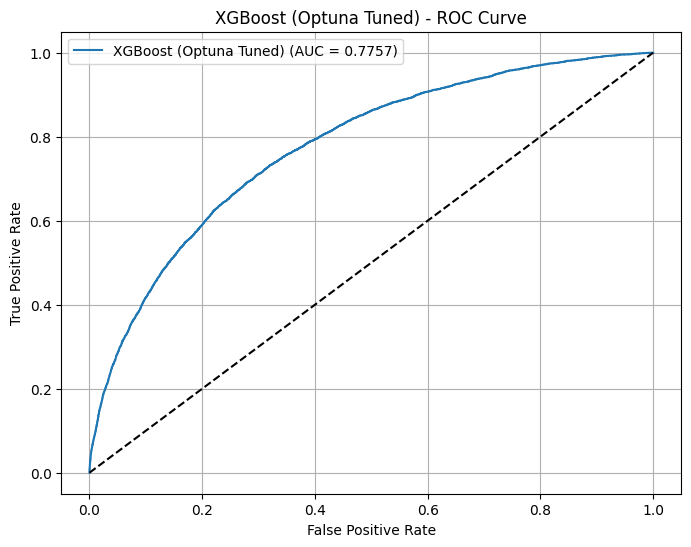


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.11246
1,EXT_SOURCE_MIN,0.03936
2,EXT_SOURCE_MAX,0.02602
20,CREDIT_GOODS_RATIO,0.01404
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.01393
101,FLAG_DOCUMENT_3,0.01369
6,CREDIT_ANNUITY_RATIO,0.01350
9,B_B_CURRENT_CREDIT_DEBT_DIFF_MIN_OVERALL,0.01163
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.01142
3,EXT_SOURCE_3,0.01100


In [19]:
# --- Model 2: XGBoost with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 3: XGBoost with Optuna Optimization & GPU")
print("="*60)

# Step 3.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=11.5,
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU if available
                               ))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "XGBoost (Baseline)")
get_feature_importance(xgb_base_pipeline.named_steps['model'], feature_names)

# Step 3.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for XGBoost ---")

def objective_xgb(trial):
    # Define hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': SEED,
        'n_jobs': 6,
        'scale_pos_weight' : 11.5,
        'tree_method': 'gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_xgb = optuna.create_study(direction='maximize',
                                study_name='xgb_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=50, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 min timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for XGBoost with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_xgb_raw = study_xgb.best_params
best_params_xgb = {f'model__{k}': v for k, v in best_params_xgb_raw.items()}
print(f"\nBest Params (XGBoost): {best_params_xgb_raw}")
print(f"Best CV ROC AUC score: {study_xgb.best_value:.4f}")

best_xgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'))
])
# Update only the tuned parameters
best_xgb_pipeline.set_params(**best_params_xgb)

print("\nFitting best XGBoost pipeline on full training data...")
best_xgb_pipeline.fit(X_train, y_train)

# Step 3.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned XGBoost model...")
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Optuna Tuned)")
get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline # Store the best pipeline  

# 5. Model 3: LightGBM


Model 4: LightGBM with Optuna Optimization & GPU

--- Baseline LightGBM Training ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18944
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 112
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 108 dense feature groups (25.34 MB) transferred to GPU in 0.010934 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469

--- Evaluation Metrics for LightGBM (Baseline) ---
AUC ROC:        0.7739
Gini Coefficient: 0.5479
KS Statistic:   0.4079
Accuracy:       0.7093
Precision:      0.1742
Rec

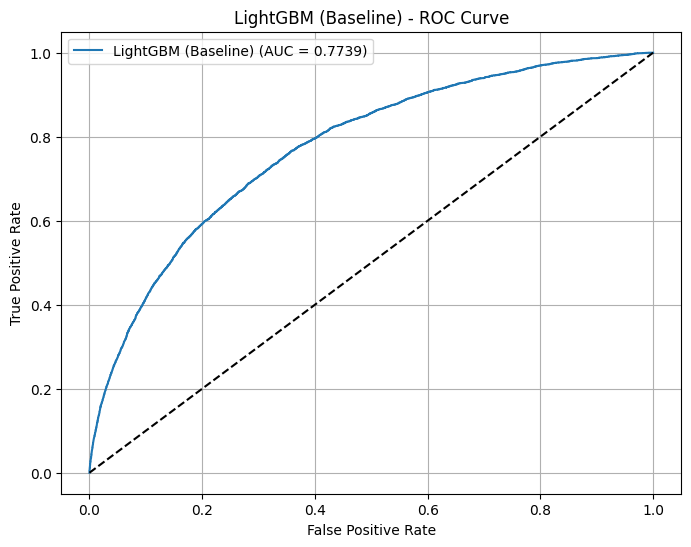


--- Top 50 Feature Importances ---
Sum of importances: 3000.0000


,feature,importance
6,CREDIT_ANNUITY_RATIO,295
0,WEIGHTED_EXT_SOURCE,109
16,DAYS_BIRTH,89
106,AMT_ANNUITY,85
20,CREDIT_GOODS_RATIO,65
10,DAYS_EMPLOYED,65
5,EXT_SOURCE_1,64
11,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,63
4,EXT_SOURCE_2,58
1,EXT_SOURCE_MIN,57


[I 2025-04-10 00:44:53,028] Using an existing study with name 'lgbm_optimization' instead of creating a new one.



--- Optuna Optimization for LightGBM ---
EarlyStoppingCallback initialized: patience=50, min_improvement=0.001
Starting Optuna optimization for LightGBM with max 100 trials (early stopping enabled)...


[I 2025-04-10 00:46:50,879] Trial 104 finished with value: 0.7675727216251674 and parameters: {'n_estimators': 962, 'learning_rate': 0.03641126032630929, 'num_leaves': 37, 'max_depth': 5, 'subsample': 0.9942084717011277, 'colsample_bytree': 0.7536369734890078, 'reg_alpha': 3.418519858016599e-05, 'reg_lambda': 0.05022238828702558}. Best is trial 39 with value: 0.7736317691972663.


First trial, best_score initialized to 0.7676


[I 2025-04-10 00:49:04,792] Trial 105 finished with value: 0.7699863692423274 and parameters: {'n_estimators': 924, 'learning_rate': 0.022629741609375472, 'num_leaves': 26, 'max_depth': 7, 'subsample': 0.9594940533992158, 'colsample_bytree': 0.7108193822641973, 'reg_alpha': 0.28694454612993914, 'reg_lambda': 5.252980073559755e-07}. Best is trial 39 with value: 0.7736317691972663.


Trial 105: New best 0.7700 (improved by 0.0024)


[I 2025-04-10 00:51:18,272] Trial 106 finished with value: 0.7663117112186197 and parameters: {'n_estimators': 900, 'learning_rate': 0.03903559447558916, 'num_leaves': 34, 'max_depth': 10, 'subsample': 0.9854678468605169, 'colsample_bytree': 0.7429522472864911, 'reg_alpha': 0.0001253885265497895, 'reg_lambda': 3.6333791725571428e-06}. Best is trial 39 with value: 0.7736317691972663.


Trial 106: No improvement (1/50). Score: 0.7663, Best: 0.7700


[I 2025-04-10 00:53:28,016] Trial 107 finished with value: 0.7623856816192642 and parameters: {'n_estimators': 736, 'learning_rate': 0.0441015965043129, 'num_leaves': 60, 'max_depth': 8, 'subsample': 0.8005268047267566, 'colsample_bytree': 0.6604724559510112, 'reg_alpha': 0.0003627251854446978, 'reg_lambda': 2.6786985412891794e-08}. Best is trial 39 with value: 0.7736317691972663.


Trial 107: No improvement (2/50). Score: 0.7624, Best: 0.7700


[I 2025-04-10 00:54:49,678] Trial 108 finished with value: 0.768769669541352 and parameters: {'n_estimators': 463, 'learning_rate': 0.01881121498568538, 'num_leaves': 28, 'max_depth': 6, 'subsample': 0.9300033783311693, 'colsample_bytree': 0.728867657761998, 'reg_alpha': 1.0489506770678026e-06, 'reg_lambda': 7.030494094813715e-05}. Best is trial 39 with value: 0.7736317691972663.


Trial 108: No improvement (3/50). Score: 0.7688, Best: 0.7700


[I 2025-04-10 00:57:10,016] Trial 109 finished with value: 0.7678020558555358 and parameters: {'n_estimators': 600, 'learning_rate': 0.02416809013437185, 'num_leaves': 89, 'max_depth': 10, 'subsample': 0.7392003962030556, 'colsample_bytree': 0.6796430127022661, 'reg_alpha': 0.00176347468960098, 'reg_lambda': 1.1578169785430872e-08}. Best is trial 39 with value: 0.7736317691972663.


Trial 109: No improvement (4/50). Score: 0.7678, Best: 0.7700


[I 2025-04-10 00:58:51,344] Trial 110 finished with value: 0.7700072476648263 and parameters: {'n_estimators': 836, 'learning_rate': 0.03385895839938834, 'num_leaves': 30, 'max_depth': 4, 'subsample': 0.7884508788433353, 'colsample_bytree': 0.6303440534322704, 'reg_alpha': 7.312881151146342e-06, 'reg_lambda': 0.3507355558369574}. Best is trial 39 with value: 0.7736317691972663.


Trial 110: No improvement (5/50). Score: 0.7700, Best: 0.7700


[I 2025-04-10 01:00:34,791] Trial 111 finished with value: 0.7650110959341583 and parameters: {'n_estimators': 565, 'learning_rate': 0.04788040251290894, 'num_leaves': 57, 'max_depth': 11, 'subsample': 0.8616510886223042, 'colsample_bytree': 0.6908552218777729, 'reg_alpha': 2.113842615444571e-06, 'reg_lambda': 0.10246437203342537}. Best is trial 39 with value: 0.7736317691972663.


Trial 111: No improvement (6/50). Score: 0.7650, Best: 0.7700


[I 2025-04-10 01:02:37,074] Trial 112 finished with value: 0.76804290917717 and parameters: {'n_estimators': 763, 'learning_rate': 0.030800851714072312, 'num_leaves': 38, 'max_depth': 10, 'subsample': 0.6061166330047832, 'colsample_bytree': 0.7662106648055974, 'reg_alpha': 2.1055728782817157e-07, 'reg_lambda': 0.00012358937920418946}. Best is trial 39 with value: 0.7736317691972663.


Trial 112: No improvement (7/50). Score: 0.7680, Best: 0.7700


[I 2025-04-10 01:04:53,018] Trial 113 finished with value: 0.7680375598746154 and parameters: {'n_estimators': 796, 'learning_rate': 0.027082151842598438, 'num_leaves': 43, 'max_depth': 10, 'subsample': 0.6881439029861465, 'colsample_bytree': 0.718781581177775, 'reg_alpha': 1.222502178030906e-07, 'reg_lambda': 0.013747966292761107}. Best is trial 39 with value: 0.7736317691972663.


Trial 113: No improvement (8/50). Score: 0.7680, Best: 0.7700


[I 2025-04-10 01:06:45,122] Trial 114 finished with value: 0.7693627017947852 and parameters: {'n_estimators': 633, 'learning_rate': 0.029148098397634985, 'num_leaves': 36, 'max_depth': 10, 'subsample': 0.6264592899678659, 'colsample_bytree': 0.7056670102957696, 'reg_alpha': 4.539370780399218e-08, 'reg_lambda': 0.0036560811580994613}. Best is trial 39 with value: 0.7736317691972663.


Trial 114: No improvement (9/50). Score: 0.7694, Best: 0.7700


[I 2025-04-10 01:08:34,359] Trial 115 finished with value: 0.7699576288479995 and parameters: {'n_estimators': 671, 'learning_rate': 0.0257119241652274, 'num_leaves': 32, 'max_depth': 7, 'subsample': 0.6400293791116988, 'colsample_bytree': 0.7309599907867498, 'reg_alpha': 1.7420029763363263e-08, 'reg_lambda': 0.000525921749649299}. Best is trial 39 with value: 0.7736317691972663.


Trial 115: No improvement (10/50). Score: 0.7700, Best: 0.7700


[I 2025-04-10 01:10:39,591] Trial 116 finished with value: 0.7697854135908176 and parameters: {'n_estimators': 756, 'learning_rate': 0.02064626784510917, 'num_leaves': 41, 'max_depth': 6, 'subsample': 0.6740626113626134, 'colsample_bytree': 0.6556880084235657, 'reg_alpha': 7.887461761571399e-08, 'reg_lambda': 0.03168017195549713}. Best is trial 39 with value: 0.7736317691972663.


Trial 116: No improvement (11/50). Score: 0.7698, Best: 0.7700


[I 2025-04-10 01:12:53,562] Trial 117 finished with value: 0.7676302202262774 and parameters: {'n_estimators': 859, 'learning_rate': 0.03289555066198622, 'num_leaves': 39, 'max_depth': 9, 'subsample': 0.6585259072405589, 'colsample_bytree': 0.6679387169012716, 'reg_alpha': 4.186128934931032e-07, 'reg_lambda': 0.7183869330161843}. Best is trial 39 with value: 0.7736317691972663.


Trial 117: No improvement (12/50). Score: 0.7676, Best: 0.7700


[I 2025-04-10 01:15:24,206] Trial 118 finished with value: 0.7687239438589751 and parameters: {'n_estimators': 812, 'learning_rate': 0.022759519269498582, 'num_leaves': 51, 'max_depth': 11, 'subsample': 0.8322924987568775, 'colsample_bytree': 0.7143650021227094, 'reg_alpha': 0.07369077144358621, 'reg_lambda': 0.001047185123588029}. Best is trial 39 with value: 0.7736317691972663.


Trial 118: No improvement (13/50). Score: 0.7687, Best: 0.7700


[I 2025-04-10 01:17:27,099] Trial 119 finished with value: 0.7686097983147059 and parameters: {'n_estimators': 873, 'learning_rate': 0.030283900775165212, 'num_leaves': 72, 'max_depth': 5, 'subsample': 0.9902327208264373, 'colsample_bytree': 0.7618000772189156, 'reg_alpha': 3.176590239020287e-08, 'reg_lambda': 0.010195953981949352}. Best is trial 39 with value: 0.7736317691972663.


Trial 119: No improvement (14/50). Score: 0.7686, Best: 0.7700


[I 2025-04-10 01:19:03,750] Trial 120 finished with value: 0.7692586492321931 and parameters: {'n_estimators': 684, 'learning_rate': 0.041466196900552504, 'num_leaves': 22, 'max_depth': 9, 'subsample': 0.9197867619276088, 'colsample_bytree': 0.6467620231528344, 'reg_alpha': 1.2472853738003644e-05, 'reg_lambda': 0.03924426736443955}. Best is trial 39 with value: 0.7736317691972663.


Trial 120: No improvement (15/50). Score: 0.7693, Best: 0.7700


[I 2025-04-10 01:20:13,810] Trial 121 finished with value: 0.7695393757318274 and parameters: {'n_estimators': 404, 'learning_rate': 0.03652564337437507, 'num_leaves': 29, 'max_depth': 10, 'subsample': 0.9731991097490703, 'colsample_bytree': 0.7867887876011868, 'reg_alpha': 2.205352934416115e-07, 'reg_lambda': 0.024490476702212962}. Best is trial 39 with value: 0.7736317691972663.


Trial 121: No improvement (16/50). Score: 0.7695, Best: 0.7700


[I 2025-04-10 01:22:37,455] Trial 122 finished with value: 0.769852929470676 and parameters: {'n_estimators': 835, 'learning_rate': 0.021145556106361076, 'num_leaves': 39, 'max_depth': 10, 'subsample': 0.9770271340399015, 'colsample_bytree': 0.6344938433996499, 'reg_alpha': 2.71251259818832e-05, 'reg_lambda': 0.07083223251696007}. Best is trial 39 with value: 0.7736317691972663.


Trial 122: No improvement (17/50). Score: 0.7699, Best: 0.7700


[I 2025-04-10 01:24:40,081] Trial 123 finished with value: 0.7698521434961487 and parameters: {'n_estimators': 724, 'learning_rate': 0.02758392559428412, 'num_leaves': 35, 'max_depth': 10, 'subsample': 0.9865862486763166, 'colsample_bytree': 0.6501794337736637, 'reg_alpha': 2.1995099452219252e-05, 'reg_lambda': 0.04023511439333782}. Best is trial 39 with value: 0.7736317691972663.


Trial 123: No improvement (18/50). Score: 0.7699, Best: 0.7700


[I 2025-04-10 01:27:05,646] Trial 124 finished with value: 0.7689493593494909 and parameters: {'n_estimators': 853, 'learning_rate': 0.02409549725769867, 'num_leaves': 43, 'max_depth': 10, 'subsample': 0.9984535654132499, 'colsample_bytree': 0.6807183057615749, 'reg_alpha': 5.502340489617669e-05, 'reg_lambda': 0.017939772281969198}. Best is trial 39 with value: 0.7736317691972663.


Trial 124: No improvement (19/50). Score: 0.7689, Best: 0.7700


[I 2025-04-10 01:29:47,895] Trial 125 finished with value: 0.769726930851631 and parameters: {'n_estimators': 886, 'learning_rate': 0.019335968882576174, 'num_leaves': 45, 'max_depth': 11, 'subsample': 0.9597414249201925, 'colsample_bytree': 0.6944010785741502, 'reg_alpha': 0.00018632223142915356, 'reg_lambda': 0.0061244924244589875}. Best is trial 39 with value: 0.7736317691972663.


Trial 125: No improvement (20/50). Score: 0.7697, Best: 0.7700


[I 2025-04-10 01:32:03,082] Trial 126 finished with value: 0.7702684216564972 and parameters: {'n_estimators': 780, 'learning_rate': 0.022248019373227505, 'num_leaves': 37, 'max_depth': 10, 'subsample': 0.9508371129309582, 'colsample_bytree': 0.6241123010160087, 'reg_alpha': 0.011727331563062484, 'reg_lambda': 0.09022307051403997}. Best is trial 39 with value: 0.7736317691972663.


Trial 126: No improvement (21/50). Score: 0.7703, Best: 0.7700


[I 2025-04-10 01:34:33,781] Trial 127 finished with value: 0.7703077025704061 and parameters: {'n_estimators': 937, 'learning_rate': 0.016684096276638458, 'num_leaves': 26, 'max_depth': 9, 'subsample': 0.7271323243562661, 'colsample_bytree': 0.6728556214154178, 'reg_alpha': 4.420253410625272e-05, 'reg_lambda': 0.0018675053441265421}. Best is trial 39 with value: 0.7736317691972663.


Trial 127: No improvement (22/50). Score: 0.7703, Best: 0.7700


[I 2025-04-10 01:36:55,242] Trial 128 finished with value: 0.7684651778884124 and parameters: {'n_estimators': 813, 'learning_rate': 0.02552745039432801, 'num_leaves': 47, 'max_depth': 7, 'subsample': 0.7076427569316638, 'colsample_bytree': 0.7447877732899372, 'reg_alpha': 7.983764468804029e-05, 'reg_lambda': 0.13939464621672903}. Best is trial 39 with value: 0.7736317691972663.


Trial 128: No improvement (23/50). Score: 0.7685, Best: 0.7700


[I 2025-04-10 01:39:11,085] Trial 129 finished with value: 0.760915639839931 and parameters: {'n_estimators': 912, 'learning_rate': 0.05533885568476946, 'num_leaves': 41, 'max_depth': 6, 'subsample': 0.9702115115159551, 'colsample_bytree': 0.6391845736159575, 'reg_alpha': 3.838780301632649e-06, 'reg_lambda': 0.22418241642540776}. Best is trial 39 with value: 0.7736317691972663.


Trial 129: No improvement (24/50). Score: 0.7609, Best: 0.7700


[I 2025-04-10 01:41:06,399] Trial 130 finished with value: 0.7681890147168052 and parameters: {'n_estimators': 743, 'learning_rate': 0.03483429912811902, 'num_leaves': 32, 'max_depth': 11, 'subsample': 0.7656635115255399, 'colsample_bytree': 0.7002363330536661, 'reg_alpha': 9.62798851113567e-06, 'reg_lambda': 0.051047329069859614}. Best is trial 39 with value: 0.7736317691972663.


Trial 130: No improvement (25/50). Score: 0.7682, Best: 0.7700


[I 2025-04-10 01:42:52,753] Trial 131 finished with value: 0.7700120225157432 and parameters: {'n_estimators': 696, 'learning_rate': 0.028003785319353092, 'num_leaves': 24, 'max_depth': 8, 'subsample': 0.6528133780272697, 'colsample_bytree': 0.7210590631559343, 'reg_alpha': 6.312559608283978e-08, 'reg_lambda': 0.011765265565167788}. Best is trial 39 with value: 0.7736317691972663.


Trial 131: No improvement (26/50). Score: 0.7700, Best: 0.7700


[I 2025-04-10 01:45:13,162] Trial 132 finished with value: 0.76987042241366 and parameters: {'n_estimators': 798, 'learning_rate': 0.02096701188713303, 'num_leaves': 39, 'max_depth': 10, 'subsample': 0.8973538251469828, 'colsample_bytree': 0.6542587992746477, 'reg_alpha': 9.614288883630894e-06, 'reg_lambda': 0.1104816038400179}. Best is trial 39 with value: 0.7736317691972663.


Trial 132: No improvement (27/50). Score: 0.7699, Best: 0.7700
Timeout: optimization stopped after 60.34 minutes


[I 2025-04-10 01:47:41,665] Trial 133 finished with value: 0.7706891406842524 and parameters: {'n_estimators': 777, 'learning_rate': 0.018463527464378467, 'num_leaves': 43, 'max_depth': 10, 'subsample': 0.9076506353452078, 'colsample_bytree': 0.6286100504575004, 'reg_alpha': 1.6844185627375054e-05, 'reg_lambda': 0.06392073546095978}. Best is trial 39 with value: 0.7736317691972663.


Trial 133: No improvement (28/50). Score: 0.7707, Best: 0.7700
Timeout: optimization stopped after 62.81 minutes


[I 2025-04-10 01:50:20,251] Trial 134 finished with value: 0.7703040209588458 and parameters: {'n_estimators': 845, 'learning_rate': 0.018217074555881348, 'num_leaves': 45, 'max_depth': 10, 'subsample': 0.943420957859888, 'colsample_bytree': 0.6428043658284338, 'reg_alpha': 2.9931026284467663e-05, 'reg_lambda': 0.4325259832633606}. Best is trial 39 with value: 0.7736317691972663.


Trial 134: No improvement (29/50). Score: 0.7703, Best: 0.7700
Timeout: optimization stopped after 65.45 minutes


[I 2025-04-10 01:52:56,341] Trial 135 finished with value: 0.7703061206018462 and parameters: {'n_estimators': 954, 'learning_rate': 0.019903494317234576, 'num_leaves': 35, 'max_depth': 10, 'subsample': 0.8743578921031853, 'colsample_bytree': 0.6191545871241264, 'reg_alpha': 1.4089285360891172e-05, 'reg_lambda': 0.025628418922919175}. Best is trial 39 with value: 0.7736317691972663.


Trial 135: No improvement (30/50). Score: 0.7703, Best: 0.7700
Timeout: optimization stopped after 68.06 minutes


[I 2025-04-10 01:55:10,621] Trial 136 finished with value: 0.7690432866453332 and parameters: {'n_estimators': 873, 'learning_rate': 0.013393032976730864, 'num_leaves': 38, 'max_depth': 5, 'subsample': 0.9283206505016816, 'colsample_bytree': 0.6076381594574322, 'reg_alpha': 1.1409894513759942e-07, 'reg_lambda': 0.01720925752957747}. Best is trial 39 with value: 0.7736317691972663.


Trial 136: No improvement (31/50). Score: 0.7690, Best: 0.7700
Timeout: optimization stopped after 70.29 minutes


[I 2025-04-10 01:57:37,901] Trial 137 finished with value: 0.7700886594852643 and parameters: {'n_estimators': 711, 'learning_rate': 0.015816488831110594, 'num_leaves': 47, 'max_depth': 9, 'subsample': 0.8437638937486872, 'colsample_bytree': 0.6885119745624327, 'reg_alpha': 3.928543465309825e-05, 'reg_lambda': 0.03935095552192231}. Best is trial 39 with value: 0.7736317691972663.


Trial 137: No improvement (32/50). Score: 0.7701, Best: 0.7700
Timeout: optimization stopped after 72.75 minutes


[I 2025-04-10 01:58:59,893] Trial 138 finished with value: 0.7687683414002597 and parameters: {'n_estimators': 355, 'learning_rate': 0.017381964394326883, 'num_leaves': 41, 'max_depth': 10, 'subsample': 0.8808301292524069, 'colsample_bytree': 0.6630008783957686, 'reg_alpha': 6.524361253257076e-06, 'reg_lambda': 0.22972717568089432}. Best is trial 39 with value: 0.7736317691972663.


Trial 138: No improvement (33/50). Score: 0.7688, Best: 0.7700
Timeout: optimization stopped after 74.11 minutes


[I 2025-04-10 02:01:24,067] Trial 139 finished with value: 0.7674251588041493 and parameters: {'n_estimators': 898, 'learning_rate': 0.03010853478998058, 'num_leaves': 40, 'max_depth': 11, 'subsample': 0.9119949778679096, 'colsample_bytree': 0.7762993911329945, 'reg_alpha': 7.044795321509563e-07, 'reg_lambda': 0.08042730230893877}. Best is trial 39 with value: 0.7736317691972663.


Trial 139: No improvement (34/50). Score: 0.7674, Best: 0.7700
Timeout: optimization stopped after 76.52 minutes


[I 2025-04-10 02:02:45,942] Trial 140 finished with value: 0.769558419471577 and parameters: {'n_estimators': 659, 'learning_rate': 0.03867285876383106, 'num_leaves': 34, 'max_depth': 4, 'subsample': 0.8872133670669804, 'colsample_bytree': 0.6367120799167539, 'reg_alpha': 0.43014663204149794, 'reg_lambda': 0.0074045413450515365}. Best is trial 39 with value: 0.7736317691972663.


Trial 140: No improvement (35/50). Score: 0.7696, Best: 0.7700
Timeout: optimization stopped after 77.88 minutes


[I 2025-04-10 02:05:59,104] Trial 141 finished with value: 0.7696348649572189 and parameters: {'n_estimators': 827, 'learning_rate': 0.011500909452878665, 'num_leaves': 63, 'max_depth': 12, 'subsample': 0.9816082741012773, 'colsample_bytree': 0.9648991017861317, 'reg_alpha': 2.046022575096511e-05, 'reg_lambda': 0.1491516039903328}. Best is trial 39 with value: 0.7736317691972663.


Trial 141: No improvement (36/50). Score: 0.7696, Best: 0.7700
Timeout: optimization stopped after 81.10 minutes


[I 2025-04-10 02:08:05,800] Trial 142 finished with value: 0.7675098392098734 and parameters: {'n_estimators': 979, 'learning_rate': 0.04263059737367262, 'num_leaves': 21, 'max_depth': 12, 'subsample': 0.9344969114892486, 'colsample_bytree': 0.7277072266405256, 'reg_alpha': 7.406395945272778e-05, 'reg_lambda': 0.0030108827210082365}. Best is trial 39 with value: 0.7736317691972663.


Trial 142: No improvement (37/50). Score: 0.7675, Best: 0.7700
Timeout: optimization stopped after 83.21 minutes


[I 2025-04-10 02:10:05,008] Trial 143 finished with value: 0.7680124743731669 and parameters: {'n_estimators': 922, 'learning_rate': 0.04483196885183689, 'num_leaves': 20, 'max_depth': 12, 'subsample': 0.9010564148524556, 'colsample_bytree': 0.7526820671884337, 'reg_alpha': 0.0005356102101019669, 'reg_lambda': 0.005051601934317205}. Best is trial 39 with value: 0.7736317691972663.


Trial 143: No improvement (38/50). Score: 0.7680, Best: 0.7700
Timeout: optimization stopped after 85.20 minutes


[I 2025-04-10 02:12:15,559] Trial 144 finished with value: 0.7649465703199942 and parameters: {'n_estimators': 970, 'learning_rate': 0.05008511827717716, 'num_leaves': 27, 'max_depth': 12, 'subsample': 0.921524036514935, 'colsample_bytree': 0.7381483552301247, 'reg_alpha': 0.00012870668465219778, 'reg_lambda': 1.3578080061766572e-07}. Best is trial 39 with value: 0.7736317691972663.


Trial 144: No improvement (39/50). Score: 0.7649, Best: 0.7700
Timeout: optimization stopped after 87.38 minutes


[I 2025-04-10 02:14:21,699] Trial 145 finished with value: 0.763194666497092 and parameters: {'n_estimators': 995, 'learning_rate': 0.06461194449197717, 'num_leaves': 23, 'max_depth': 5, 'subsample': 0.9628461750577625, 'colsample_bytree': 0.7112063427309001, 'reg_alpha': 0.001171787948236271, 'reg_lambda': 0.0012590457543406814}. Best is trial 39 with value: 0.7736317691972663.


Trial 145: No improvement (40/50). Score: 0.7632, Best: 0.7700
Timeout: optimization stopped after 89.48 minutes


[I 2025-04-10 02:16:18,314] Trial 146 finished with value: 0.7701885639726599 and parameters: {'n_estimators': 754, 'learning_rate': 0.023829194179688238, 'num_leaves': 24, 'max_depth': 10, 'subsample': 0.9139355392915903, 'colsample_bytree': 0.7478559873531782, 'reg_alpha': 0.003606478922264636, 'reg_lambda': 0.5510800746364088}. Best is trial 39 with value: 0.7736317691972663.


Trial 146: No improvement (41/50). Score: 0.7702, Best: 0.7700
Timeout: optimization stopped after 91.42 minutes


[I 2025-04-10 02:18:45,785] Trial 147 finished with value: 0.7646639334346818 and parameters: {'n_estimators': 956, 'learning_rate': 0.04004471882921813, 'num_leaves': 42, 'max_depth': 8, 'subsample': 0.9538458555305753, 'colsample_bytree': 0.6129985346534449, 'reg_alpha': 0.0002969889347120275, 'reg_lambda': 0.05467949089480497}. Best is trial 39 with value: 0.7736317691972663.


Trial 147: No improvement (42/50). Score: 0.7647, Best: 0.7700
Timeout: optimization stopped after 93.88 minutes


[I 2025-04-10 02:21:29,677] Trial 148 finished with value: 0.7653241720765871 and parameters: {'n_estimators': 865, 'learning_rate': 0.033169727968809924, 'num_leaves': 66, 'max_depth': 12, 'subsample': 0.8092091239844552, 'colsample_bytree': 0.7044906674564525, 'reg_alpha': 2.730202500516434e-06, 'reg_lambda': 0.9970060015517312}. Best is trial 39 with value: 0.7736317691972663.


Trial 148: No improvement (43/50). Score: 0.7653, Best: 0.7700
Timeout: optimization stopped after 96.61 minutes


[I 2025-04-10 02:23:53,794] Trial 149 finished with value: 0.7685201871990934 and parameters: {'n_estimators': 887, 'learning_rate': 0.02612069577295252, 'num_leaves': 37, 'max_depth': 11, 'subsample': 0.6227401276706991, 'colsample_bytree': 0.735887156221318, 'reg_alpha': 2.717111247366729e-05, 'reg_lambda': 0.03263728479816592}. Best is trial 39 with value: 0.7736317691972663.


Trial 149: No improvement (44/50). Score: 0.7685, Best: 0.7700
Timeout: optimization stopped after 99.01 minutes


[I 2025-04-10 02:25:50,466] Trial 150 finished with value: 0.7701137572327748 and parameters: {'n_estimators': 725, 'learning_rate': 0.021836964507131792, 'num_leaves': 25, 'max_depth': 10, 'subsample': 0.7575887318565298, 'colsample_bytree': 0.6459885747932186, 'reg_alpha': 3.1898244571003584e-07, 'reg_lambda': 0.0022305751689998673}. Best is trial 39 with value: 0.7736317691972663.


Trial 150: No improvement (45/50). Score: 0.7701, Best: 0.7700
Timeout: optimization stopped after 100.96 minutes


[I 2025-04-10 02:27:56,979] Trial 151 finished with value: 0.7689389468569223 and parameters: {'n_estimators': 910, 'learning_rate': 0.035844606638070355, 'num_leaves': 22, 'max_depth': 9, 'subsample': 0.7797387954468391, 'colsample_bytree': 0.7250362662148643, 'reg_alpha': 1.6477681656761154e-07, 'reg_lambda': 1.0159107836127476e-05}. Best is trial 39 with value: 0.7736317691972663.


Trial 151: No improvement (46/50). Score: 0.7689, Best: 0.7700
Timeout: optimization stopped after 103.07 minutes


[I 2025-04-10 02:30:19,932] Trial 152 finished with value: 0.769992928678467 and parameters: {'n_estimators': 876, 'learning_rate': 0.021821460067638906, 'num_leaves': 33, 'max_depth': 10, 'subsample': 0.9399908783451408, 'colsample_bytree': 0.6513143304286985, 'reg_alpha': 4.251828955878817e-06, 'reg_lambda': 0.10096122403987232}. Best is trial 39 with value: 0.7736317691972663.


Trial 152: No improvement (47/50). Score: 0.7700, Best: 0.7700
Timeout: optimization stopped after 105.45 minutes


In [ ]:
# --- Model 3: LightGBM with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 4: LightGBM with Optuna Optimization & GPU")
print("="*60)

print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=6, scale_pos_weight=11.5,
                                 device='gpu' if device_name == 'cuda' else 'cpu' # Enable GPU if available
                                ))
])

lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

print("\n--- Optuna Optimization for LightGBM ---")

def objective_lgbm(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': 5,
        'device': 'gpu' if device_name == 'cuda' else 'cpu', # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight' : 11.5,
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Optional: depends on dataset size
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMClassifier(**param))
    ])

    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        # LightGBM can sometimes throw errors with certain parameter combos
        print(f"Trial failed with error: {e}")
        return 0.0

study_lgbm = optuna.create_study(direction='maximize',
                                study_name='lgbm_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

early_stopping = EarlyStoppingCallback(patience=50, min_improvement=0.001)
timeout = TimeoutCallback(timeout=3600)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for LightGBM with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_lgbm_raw = study_lgbm.best_params
best_params_lgbm = {f'model__{k}': v for k, v in best_params_lgbm_raw.items()}
print(f"\nBest Params (LightGBM): {best_params_lgbm_raw}")
print(f"Best CV ROC AUC score: {study_lgbm.best_value:.4f}")

best_lgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=5,
                                 device='gpu' if device_name == 'cuda' else 'cpu'))
])
# Update only the tuned parameters
best_lgb_pipeline.set_params(**best_params_lgbm)

print("\nFitting best LightGBM pipeline on full training data...")
best_lgb_pipeline.fit(X_train, y_train)

print("\nEvaluating tuned LightGBM model...")
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Optuna Tuned)")
get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline 

# 8. Model Evaluation

In [ ]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model') # Now contains Optuna results

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "baseline_model_results.csv"))
tuned_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "tuned_model_results_optuna.csv")) # Updated filename
print(f"\nResults saved to {MODEL_OUTPUT_PATH}")

# Optionally save the best models
model_save_path = os.path.join(MODEL_OUTPUT_PATH, 'best_models_optuna.pkl')
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(model_objects, f)
    print(f"Best model objects saved to {model_save_path}")
except Exception as e:
    print(f"Could not save models: {e}")

# Optionally save the Optuna studies (they are also saved to the sqlite DB)
study_sgd.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_sgd_trials.csv'))
study_xgb.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_xgb_trials.csv'))
study_lgbm.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_lgbm_trials.csv'))

# Save the most important features from the best models
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.nan # Placeholder, will fill with actual importance later
})
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance_df[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance_df[model_name] = np.abs(model.coef_[0]) # For linear models
    else:
        feature_importance_df[model_name] = np.nan

feature_importance_df = feature_importance_df.set_index('Feature').fillna(0) # Fill NaN with 0 for missing models
feature_importance_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, 'feature_importances.csv'))
print(f"\nFeature importances saved to {MODEL_OUTPUT_PATH}feature_importances.csv")

print("\nModeling complete.")


Overall Model Comparison

--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Baseline),0.77510,0.55021,0.41370,0.71398,0.17659,0.69426,0.28156,0.18447,0.54468
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
XGBoost (Baseline),0.75446,0.50893,0.37912,0.75380,0.18533,0.60363,0.28359,0.16483,0.49610
SGDClassifier (Baseline),0.72580,0.45159,0.33871,0.67682,0.15228,0.65760,0.24729,0.21175,0.63249



--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Optuna Tuned),0.77845,0.55691,0.41835,0.70515,0.17482,0.71299,0.28080,0.06621,0.23923
XGBoost (Optuna Tuned),0.77773,0.55547,0.41597,0.67068,0.16361,0.74884,0.26854,0.06630,0.23952
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
SGDClassifier (Optuna Tuned),0.75644,0.51288,0.37752,0.67536,0.15846,0.70091,0.25849,0.20022,0.58677



Results saved to ./model_outputs/
Best model objects saved to ./model_outputs/best_models_optuna.pkl

Feature importances saved to ./model_outputs/feature_importances.csv

Modeling complete.
